## Steps 1 and 2: Download the HMEQ Data set and Read the data into Python:



First I import the different libraries that I will be using to explore and visualize this data. Next, I set the Pandas `set_option` values to facilitate displaying the information. Next, I download the HMEQ Data set from Canvas and upload it into the same folder as this Google Colaboratory Notebook. Next, I import the data into a Pandas DataFrame object called `df`.
Lastly, I print out the first five (5) values from the dataset using `.head()` and using `.T` to transpose the data so that it will visually fit on the screen.

In [2]:
import math
import itertools
import time

import pandas as pd
import numpy as np
from operator import itemgetter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
"""
COLLECTING DECISION TREE VARIABLES
"""

def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

In [5]:
"""
COLLECTING ENSEMBLE TREE (RANDOM FOREST / GRADIENT BOOSTING) VARIABLES
"""

def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

In [6]:
"""
MODEL ACCURACY METRICS
"""

def getProbAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    probs = MODEL.predict_proba( X )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

def print_ROC_Curve( TITLE, LIST ) :
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nDEFAULT")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nVALUE OF LOAN DEFAULT")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

def get_TF_ProbAccuracyScores( NAME, MODEL, X, Y ) :
    probs = MODEL.predict_proba( X )
    pred_list = []
    for p in probs :
        pred_list.append( np.argmax( p ) )
    pred = np.array( pred_list )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

In [7]:
INFILE = '/content/drive/MyDrive/Northwestern/MSDS 422/2021-04-11 Assignment 01/HMEQ_Loss.csv'

In [8]:
df = pd.read_csv( INFILE )
dt = df.dtypes

In [9]:
#@title
# 4/19/2021 Commented out for speed.

# # print( df.head().T ) #Print variable in a .py file, but we're in using Notebook
# df.head().T

## Step 3: Explore both the input and target variables using statistical techniques

### Statistics using `len()` and `.description()`

After viewing the first five rows of this dataframe, I confirm that the variables `TARGET_BAD_FLAG` and `TARGET_LOSS_AMT` are the two target variable for the analysis. So I establish these as variables for ease of reference:

In [20]:
TARGET_F = "TARGET_BAD_FLAG"
TARGET_A = "TARGET_LOSS_AMT"

The `len` function allows me to determine the total number of rows in the dataframe and the `.describe()` function allows me to see the statistical description for this dataframe.

In [21]:
#@title
# 4/19/2021 Commented out for speed.

# print( len(df) )

In [22]:
#@title
# 4/19/2021 Commented out for speed.

# dfStats = df.describe()

In [23]:
#@title
# 4/19/2021 Commented out for speed.

# print( dfStats.T ) #Print variable in a .py file, but we're in using Notebook
# # dfStats.T #Use print() if too wide to view in PDF document

In [24]:
#@title
# 4/19/2021 Commented out for speed.

# print(f'The mean value of {TARGET_F} is {dfStats[TARGET_F]["mean"]}')

### **Discuss any observations and interpretations (Statistics):**

At a high level I note the following important statistics:

* There are a total of 5960 rows of data in this dataframe
* `TARGET_BAD_FLAG` takes on values of either 0 or 1. The average of this variable is 20% with a SD of 0.4, which means that 20% of the values within the dataset have a "Loss" (Value = 1)
* `TARGET_LOSS_AMT` average is \$13,415 (with a SD of \$10,839) and ranges from a min of \$224 to a max of \$78,987
* The input variable with the least number of missing values is the `LOAN` variable, as it has the same number of rows (5960) as the entire dataframe, so has no missing values.
* The input variable with the most number of missing values is the `DEBTINC` variable.



### Reviewing and ensuring consistent data types

By using the `.dtypes()` function I am able to see what type of data is included in each column of the dataframe. This allows me to determine that the `REASON` and `JOB` columns are categorical variables, while all others are numerical variables. I do notice that it will make my analysis more organized if I convert the `LOAN` column from integers to float values, so I complete this data type transformation using the `.astype()` function.

In [25]:
#@title
# 4/19/2021 Commented out for speed.

# dt = df.dtypes
# print( dt )

In [26]:
df.LOAN = df.LOAN.astype(float)

In [27]:
#@title
# 4/19/2021 Commented out for speed.

# dt = df.dtypes
# print( dt )

### Organizing the data into categorical and numerical variables

To streamline analysis later on, I now group each column, *except for the target variables*, into either categorical variable list or numerical variable list. With these organized lists, I now have the `REASON` and `JOB` categorical variables included within the `objList` list and numerical variables included within the `numList` list (note there are no integer variables, so need for a `intList` is not relevant to this data set).

In [28]:
objList = []
numList = []
for i in dt.index :
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64","int64"]) : numList.append( i )


In [29]:
#@title
# 4/19/2021 Commented out for speed.

# print("\n OBJECTS ")
# print(" ------- ")
# for i in objList :
#    print(i)

# print("\n NUMBERS ")
# print(" ------- ")
# for i in numList :
#    print(i)

## Step 4: Explore both the input and target variables using graphs and other visualization.

### Display distribution of categorical variables (Pie Charts).

To visualize the distribution of the categorical variables, I create pie charts that display the total counts of both the `REASON` and `JOB` variables, as a percentage of the total dataframe.

In [30]:
#@title
# 4/19/2021 Commented out for speed.

# for i in objList :
#    x = df[ i ].value_counts(dropna=False)
#    #print( x )
#    theLabels = x.axes[0].tolist()
#    #print( theLabels )
#    theSlices = list(x)
#    #print( theSlices ) 
#    plt.pie( theSlices,
#             labels=theLabels,
#             startangle = 90,
#             shadow=True,
#             autopct="%1.1f%%")
#    plt.title("Pie Chart: " + i)
#    plt.show()

### Display distribution of numerical variables (Histograms).

To visualize the distribution of the numerical variables, I create histograms that display the bin distributions of each variable, as a total count (y-axis) per bin (x-axis).

In [31]:
#@title
# 4/19/2021 Commented out for speed.

# for i in numList :
#     plt.hist( df[ i ] )
#     plt.xlabel( i )
#     plt.show()

### **Discuss any observations and interpretations (Histograms):**

The majority of the variables in this data set are skewed to the right, with short tails on values less than the median and longer tails on values greater than the median. The most normally distributed variables appear to be 
* `CLAGE` (credit line age), 
* `CLNO` (number of credit cards held), and 
* `DEBTINC` (debt to income ratio). 

It would also appear that there are upper end outliers in most, if not all, of the variables. So we should explore these outliers in future work.

### Display distribution of the target variable `TARGET_LOSS_AMT` (Histogram).

As a finalize visualization in the base EDA (see some bonus visualizations below) I visualize the distribution of the target variable `TARGET_LOSS_AMT` for this dataframe by creating a histogram that displays the bin distributions of the target variable, as a total count (y-axis) per bin (x-axis).

In [32]:
#@title
# 4/19/2021 Commented out for speed.

# plt.hist( df[ TARGET_A ] )
# plt.xlabel( "Loss Amount" )
# plt.show()

### **Discuss any observations and interpretations (Target Variable):**

The target variable `TARGET_LOSS_AMOUNT` in this data set is also skewed to the right, with the median being in the smallest bin - between \$0 and \$10,000. There does appear to be the potential for an upper outlier(s). So we should explore further in future work.

## Step 5: Look for relationships between the input variables and the targets.


### Review statistics by category using `.groupby()` function

I review some key statistics of the target variables `TARGET_BAD_FLAG` and `TARGET_LOSS_AMT` -- including `.count()` and `.mean()` of both target variables, to see how they might differ based upon grouping by categorical variables. This provides a way of determining which categorical variables seem to be predictive and which are not. In this dataframe, the two categorical variables are `REASON` and `JOB`. 

In [33]:
#@title
# 4/19/2021 Commented out for speed.

# for i in objList :
#    print(" Class = ", i )
#    g = df.groupby( i )
#    print( g[i].count() )
#    x = g[ TARGET_F ].mean()
#    print( " ................. ")
#    print( "Avg Loan Default Prob", x )
#    print( " ................. ")
#    x = g[ TARGET_A ].mean()
#    print( "Avg Loan Default Amount", x )
#    print(" ===============\n\n\n ")

### **Discuss any observations and interpretations (Relationships between input variables and targets):**

When considering the categorical variable `REASON`, I observe that there are more Debt Consolidation defaults (3,928 total) than Home Improvement consolidations (1,780 total) and the average Loss Amount for Debt Consolidations is higher (\$16,005) than Home Improvement Loss Amounts (\$8,388). However, the average percentage of Defaulted loans is higher for Home Improvements than for Debt Consolidation (22% vs 19%).

When considering the categorical variable `JOB` I observe that a significant number of defaults do not have a job classification (i.e. `Other`) so this might prove to be a more challenging categorical variable to accurately predict defaults. The job with the highest likelyhood of default is `Sales` at 35% and the highest average Loss Amount is for self-employed individuals (`Self`) with an average loss amount of $22,232.

### **Looking for relationships using Correlations and Heatmaps**



I first take a look at any strong correlations that may exist within the dataset.  This is accomplished by first selecting the columns that contain all of the numerical data rather than the categorical data. Then I apply the corr() function to this numerical dataset to see how each of the variables are correlated.  As a final step to this first analysis, I present the results of the correlation analysis using a Seaborn Heatmap (`sns.heatmap()`) so that strongly correlated values are easy to identify.

In [34]:
#@title
# 4/19/2021 Commented out for speed.

# df_corr = df.drop(labels=objList, axis=1).copy()
# corrmat = df_corr.corr()
# mask = np.triu(np.ones_like(corrmat, dtype = bool))

# fig, ax = plt.subplots(figsize=(10,10))
# sns.heatmap(corrmat, ax=ax, vmax = 0.5, square = True, mask = mask, annot = True, cmap = 'RdYlBu', linewidths = 0.6)
# ax.set_title('Correlations in the HMEC Dataset (Blue = Strong Correlation / Red = Weak)')
# plt.yticks(rotation=0)
# plt.show()

I see right away that, not surprisely, that there are strong correlations between the following variables:  `TARGET_LOSS_AMT` and `LOAN`. This makes sense because the larger the loan, the larger the loss amount can be.  The other "obvious" correlation is between `MORTDUE` and `VALUE`. Due to the very high correlation (0.88) this might be a method of imputing missing numerical values (by using a linear regression estimator between these two variables) so we might want to explore that later on.

There are also some variables which seem to predict `TARGET_BAD_FLAG`, the strongest correlations are, in order: 

* `DELINQ` (0.35)
* `DEROG` (0.28)

### **Looking for relationships using Pairplots**

For the variables which appear to show the most correlation to the target variable `TARGET_LOSS_AMT` I now prepare a visual to generally depict the correlations for the top five variables.

With a Seaborn `pairplot`, I am able to see histograms (on the diagonal) for each of the top 5 variables as well as scatterplots for the relationships between each variable. Generally (as the correlation heatmaps revealed previously), each of the variables are positively correlated.




In [35]:
#@title
# 4/19/2021 Commented out for speed.

# columns_reduced = ['TARGET_LOSS_AMT', 'LOAN', 'MORTDUE', 'VALUE', 'CLNO', 'DEBTINC']
# sns.pairplot(df_corr[columns_reduced])
# plt.show()

## Step 6: Fix (impute) all missing data.

### Missing Value Imputation For Numeric Variables

In [36]:
#@title
# 4/19/2021 Commented out for speed.

# for i in numList :
#     g = df.groupby( i )
#     #print( g[i].count() )
#     print(i)
#     print( "MEDIAN = ", df[i].median() ) # The [0] returns the index 0  
#     print( "MISSING = ", df[i].isna().sum() )
#     print( "\n")

In [37]:
M_columns = []

for i in numList :
    if df[i].isna().sum() == 0 : continue
    FLAG = "M_" + i
    M_columns.append(FLAG)
    IMP = "IMP_" + i
    #print(i)
    #print( df[i].isna().sum() )
    #print( FLAG )
    #print( IMP )
    #print(" ------- ")
    df[ FLAG ] = df[i].isna() + 0
    df[ IMP ] = df[ i ]
    df.loc[ df[IMP].isna(), IMP ] = df[i].median()
    df = df.drop( i, axis=1 )

# 4/19/2021 Commented out for speed.

# df.head().T

In [38]:
#@title
# 4/19/2021 Commented out for speed.

# print(df.describe().T)

### Missing Value Imputation For Class Variables

Look at the cardinality of each categorical variable. If there are too many values within each category then consider removing from the data set. But in this current data set, there are a limited number of categories (only 2 for the `REASON` variable and 6 for the `JOB` variable).

In [39]:
#@title
# 4/19/2021 Commented out for speed.

# for i in objList :
#     print( i )
#     print( df[i].unique() )

In [40]:
#@title
# 4/19/2021 Commented out for speed.

# for i in objList :
#     g = df.groupby( i )
#     print( g[i].count() )
#     print( "MOST COMMON = ", df[i].mode()[0] ) # The [0] returns the index 0  
#     print( "MISSING = ", df[i].isna().sum() )
#     print( "\n\n")

As a first pass through the data, I elect to fill in all missing categorical values with the word "MISSING". Alternatives could include filling in with the most common value, or using some business rule to fill in the value based upon some other variable (if there is expected to be a very high correlation).

We can revisit this decision at a later time to see if we can improve our model.

In [41]:
"""
FILL IN MISSING WITH THE CATEGORY "MISSING"
"""
for i in objList :
    if df[i].isna().sum() == 0 : continue
    #print( i ) 
    #print("HAS MISSING")
    NAME = "IMP_"+i
    #print( NAME ) 
    df[NAME] = df[i]
    df[NAME] = df[NAME].fillna("MISSING")
    #print( "variable",i," has this many missing", df[i].isna().sum() )
    #print( "variable",NAME," has this many missing", df[NAME].isna().sum() )
    g = df.groupby( NAME )
    #print( g[NAME].count() )
    #print( "\n\n")
    df = df.drop( i, axis=1 )

In [42]:
'''
Rerun the creation of the object list, updated to include imputed values
'''
dt = df.dtypes
objList = []
for i in dt.index :
    #print(" here is i .....", i , " ..... and here is the type", dt[i] )
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["object"]) : objList.append( i )

## Step 7: Convert all categorical variables into numeric variables (One Hot Encoding)

### One Hot Encoding of Class Variables

First let's look again at the different unique values that each of our categorical variables has within the data set.

In [43]:
#@title
# 4/19/2021 Commented out for speed.

# for i in objList :
#     print(" Class = ", i )
#     print( df[i].unique() )

Before we start the one hot encoding, I decided to create a copy of the DataFrame so that I can show how to complete a one hot encoding using the Library `sklearn` which is similar to the Pandas `get_dummies()` function, 

In [44]:
#@title
# 4/19/2021 Commented out for speed.

# dfBonus = df.copy()

Then let's look again at some of the key statistics of the target variables `TARGET_BAD_FLAG` and `TARGET_LOSS_AMT` -- including `.count()` and `.mean()` of both target variables. This provides a way of determining which categorical variables seem to be predictive and which are not.

In [45]:
#@title
# 4/19/2021 Commented out for speed.

# for i in objList :
#    print(" Class = ", i )
#    g = df.groupby( i )
#    print( g[i].count() )
#    x = g[ TARGET_F ].mean()
#    print( " ................. ")
#    print( "Avg Loan Default Prob", x )
#    print( " ................. ")
#    x = g[ TARGET_A ].mean()
#    #x = g[ TARGET_A ].median()
#    print( "Avg Loan Default Amount", x )
#    print(" ===============\n\n\n ")

Finally, we use the `pd.get_dummies` function to create one-hot encoded variables, each of which has a prefix of `z_`.

In [46]:
for i in objList :
    #print(" Class = ", i )
    thePrefix = "z_" + i
    #print( thePrefix )
    y = pd.get_dummies( df[i], prefix=thePrefix, dummy_na=False )  
    # USE drop_first=True IF DATA IS BINARY, MINIMIZES NUMBER OF VARIABLES ADDED 
    #y = pd.get_dummies( df[i], prefix=thePrefix, drop_first=True )
    #print( type(y) )
    #print( y.head().T )
    df = pd.concat( [df, y], axis=1 )
    df = df.drop( i, axis=1 )

# print( df.head().T ) #Print variable in a .py file, but we're in using Notebook

# 4/19/2021 Commented out for speed.

# df.head().T

### **One Hot Encoding of Class Variables Using `sklearn.preprocessing.OneHotEncoder`**

After reading through some of the documentation available in the Python Package `scikit learn` I decided to try to see how the function `.OneHotEncoder()` works as compared to the `pd.get_dummies` function.

I found this code to be relatively easy to implement. And because this functionality is self-contained within the `scikit learn` library, there might be some advantages to using this method for consistency of using the same library throughout the entire Machine Learning process. Perhaps?

In [47]:
#@title
# 4/19/2021 Commented out for speed.

# enc = OneHotEncoder(handle_unknown='ignore')

# for i in objList :
#     #print(" Class = ", i )
#     thePrefix = "z_" + i
#     #print( thePrefix )
#     x = pd.DataFrame(dfBonus[i])
#     enc.fit(x)
#     print(enc.categories_[0])
#     newPrefix = thePrefix + "_" + enc.categories_[0]
#     print(newPrefix)
#     y = pd.DataFrame(enc.transform(x).toarray(), columns = newPrefix)
#     dfBonus = pd.concat( [dfBonus, y], axis=1 )
#     dfBonus = dfBonus.drop( i, axis=1 )

# # print( df.head().T ) #Print variable in a .py file, but we're in using Notebook
# dfBonus.head().T

## Step 8: Address Outliers (Added for Regression Analysis)


#### Select the Numeric Variables

First, we go back to the initial pre-processing of the DataFrame to identify the numerical variables that are contained within.

In [48]:
# 5/7/2021 Commented out for speed.

# dt = df.dtypes
# dt

As a matter of good housekeeping, I do not want to change the Missing Flag Variables (`M_`) so I convert these variables into `uint8` data types.

In [49]:
for i in M_columns:
  df[i] = np.uint8(df[i])

In [50]:
dt = df.dtypes

# 5/7/2021 Commented out for speed.
# dt

With the missing flag variables now converted to `uint8` data type, I now re-run the code needed to create our full `numList` list of numerical variables that will be analyzed for outliers.

In [51]:
numList = []
for i in dt.index :
    #print(i, dt[i])
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["float64","int64"]) : numList.append( i )
    #if dt[i] in (["float64"]) : numList.append( i )

# 5/7/2021 Commented out for speed.

# for i in numList:
#    print(i)

#### Analyze Numeric Variables for Outliers

In [52]:
# 5/7/2021 Commented out for speed.

# print(" NUMBER ")
# print(" ------- ")
# for i in numList :
#    print( df[i].describe() )
#    print(" -------\n ")

In [53]:
# 5/7/2021 Commented out for speed.

# for i in numList :
#    print( i )
#    plt.hist( df[ i ] )
#    plt.xlabel( i )
#    plt.show()

Comments on outliers observed:

* All numeric variables, with perhaps the exception of `IMP_YOJ` and `IMP_CLNO` appear to have outliers at the upper extreme of each range. 
* So I will utilize the methodology used in previous lectures to handle these outliers.

#### Replace Outliers

Replacing outliers in the upper extreme of each numeric variable is based upon calculating the `mean()`, the `std()` and the `max()`:

* A variable called `theCutoff` sets an upper limit of 3 standard deviations above the mean.
* If `max()` is less than `theCutoff` then no outliers are present.
* Else:
 * Establish a flag variable `O_` which identifies if a value is an outlier that has been corrected.
 * Establish a truncated variable `TRUNC_` which:
   * If variable value is less than the `theCutoff` leave as-is
   * If variable value is greater than `theCutoff`, set the value to `theCutoff`

In [54]:
O_columns = []

for i in numList :
    #print(" ------- ")
    #print(i)
    theMean = df[i].mean()
    theSD = df[i].std()
    theMax = df[i].max()
    theCutoff = round( theMean + 3*theSD )
    if theMax < theCutoff : continue
    FLAG = "O_" + i
    O_columns.append(FLAG)
    TRUNC = "TRUNC_" + i
    df[ FLAG ] = ( df[i] > theCutoff )+ 0
    df[ TRUNC ] = df[ i ]
    df.loc[ df[TRUNC] > theCutoff, TRUNC ] = theCutoff
    df = df.drop( i, axis=1 )

In [55]:
for i in O_columns:
  df[i] = np.uint8(df[i])

In [56]:
# 5/7/2021 Commented out for speed.

# df.describe()

In [57]:
dt = df.dtypes
numList = []
for i in dt.index :
    #print(i, dt[i])
    if i in ( [ TARGET_F, TARGET_A ] ) : continue
    if dt[i] in (["float64","int64"]) : numList.append( i )
    #if dt[i] in (["float64"]) : numList.append( i )

# 5/7/2021 Commented out for speed.

# for i in numList :
#     print(i)

In [58]:
# 5/7/2021 Commented out for speed.

# print(" ------- ")
# print(" NUMBER ")
# print(" ------- ")
# for i in numList :
#    print( df[i].describe() )
#    print(" -------\n ")

In [59]:
# 5/7/2021 Commented out for speed.

# for i in numList :
#    print( i )
#    plt.hist( df[ i ] )
#    plt.xlabel( i )
#    plt.show()

## Pre-Process the Data Set:

See Assignment 01 above, Steps 1 through 7 address the data preparation that must occur immediately prior to creating the training and test data sets, summarized below:

* Step 1: Download the HMEQ Data set
* Step 2: Read the data into Python
* Step 3: Explore both the input and target variables using statistical techniques
* Step 4: Explore both the input and target variables using graphs and other visualization.
* Step 5: Look for relationships between the input variables and the targets.
* Step 6: Fix (impute) all missing data.
* Step 7: Convert all categorical variables into numeric variables (One Hot Encoding)


## Create a Training and Test Data Set

With the DataFrame `df` now prepared for analysis, the first step in building a machine learning model is the split a copy (creating a copy is a recommended best practice) of the DataFrame into a Training Data Set called `X` which includes all variables *except* for the target variables `TARGET_F` and `TARGET_A`. 

The target variables `TARGET_F` and `TARGET_A` are stored in a new DataFrame called `Y`.  

The function `train_test_split()` is imported from the `sklearn.model_selection` package. It takes `X` and `Y` as inputs and splits these two DataFrames into four (4) DataFrames:

* `X_train` contains a random subset of a specified percentage (specified by `train_size`) of `X`. In our model, we have specified that 80% of the values of `X` be split into the training set.
* `Y_train` contains a subset of `Y`, corresponding to exactly the same rows as contained in `X_train`.
* `X_test` contains a random subset of a specified percentage (specified by `test_size`) of `X`. In our model, we have specified that 20% of the values of `X` be split into the test set.
* `Y_test` contains a subset of `Y`, corresponding to exactly the same rows as contained in `X_test`.
* By setting the `random_state` input to equal `1` we can create repeatable results and statistics as we analyze different models.

At the same time as creating these train and test subsets, we also create sub-subsets of `X` and  `Y`, called `W` and `Z` for use to create a ML model for the continuous target variable `TARGET_A`. The reason for this is because the `X` and `Y` target variables where `Flag = 0` will have a continuous target variable value of `NaN`, which must be removed from the train and test datasets.


### Review Option to include `O_` variables

The `O_` Flag Variables which were added during the "Address Outliers" section above, to indicate whether a value has been imputted or not, may or may not have an effect on the accuracy of my models. So, I decide to run All Models (Tree, Random Forest, Gradient Boosting and Regression) twice:

* First pass will include the `O_` flag variables
* Second pass will not include the `O_` flag variables

In [60]:
"""
SPLIT DATA
"""

X = df.copy()
X = X.drop( TARGET_F, axis=1 )
X = X.drop( TARGET_A, axis=1 )

# First Pass - Include O_Variables
# Do Nothing

# Second Pass - Omit O_Variables
X = X.drop( O_columns, axis=1)

Y = df[ [TARGET_F, TARGET_A] ]

#Use random_state=1 to set RNG to produce repeatable results
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1)

#Use with default random_state to produce random results
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2 )

print( "FLAG DATA" )
print( "TRAINING = ", X_train.shape )
print( "TEST = ", X_test.shape )

'''
Create a subset of X, Y that is W, Z for the continuous target variable
The reason for this is because the X, Y target variables where Flag = 0
have a continuous target variable value of NaN, which must be removed.
'''

F = ~ Y_train[ TARGET_A ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_A ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()


# print( Z_train.describe() )
# print( Z_test.describe() )
# print( "\n\n")

# '''This would be a method for addressing outliers 
# in the continuous target variable 
# (in this case damages > $30,000)
# '''

# F = Z_train[ TARGET_A ] > 30000
# Z_train.loc[ F, TARGET_A ] = 30000

# F = Z_test[ TARGET_A ] > 30000
# Z_test.loc[ F, [TARGET_A] ] = 30000

# print( Z_train.describe() )
# print( Z_test.describe() )
# print( "\n\n")


##print( " ====== ")
##
##print( "AMOUNT DATA" )
##print( "TRAINING = ", W_train.shape )
##print( "TEST = ", Z_test.shape )


FLAG DATA
TRAINING =  (4768, 29)
TEST =  (1192, 29)



## ***Decision Trees:***



### **Develop a decision tree to predict the probability of default**



#### Calculate the accuracy of the model on both the training and test data set

We now build a Decision Tree ML model. 

* The `fm01_Tree` variable establishes the type of model to be used -- in this case a decision tree `tree.DecisionTreeClassifier()`, and specifying the fit data using `.fit()`. These functions are imported from the `sklearn` package.

* Once the parameters have been set the `.predict()` function creates a prediction DataFrame for both train and test.

* Since the values of the target variables are actually known for both `Y_train` and `Y_test` the accuracy of the model (as a percentage of how many values are accurately predicted) can be determined by using the `metrics.accuracy_score` function (from the `sklearn.metrics` package).

In [61]:
#@title
# LOAN DEFAULT PROBABILITY ORIGINAL CODE

# #fm01_Tree = tree.DecisionTreeClassifier() # Overfitting exhibited Train @ 0.8742
# fm01_Tree = tree.DecisionTreeClassifier( max_depth=3 ) #Best Test/Train balance @0.8826 
# fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_F ] )

# Y_Pred_train = fm01_Tree.predict(X_train)
# Y_Pred_test = fm01_Tree.predict(X_test)

# print("\n=============\n")
# print("DECISION TREE\n")
# print("Probability of loan default")
# print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
# print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))
# print("\n")

In [62]:
X_train.head()

,M_MORTDUE,M_VALUE,M_YOJ,M_DEROG,M_DELINQ,M_CLAGE,M_NINQ,M_CLNO,M_DEBTINC,z_IMP_REASON_DebtCon,z_IMP_REASON_HomeImp,z_IMP_REASON_MISSING,z_IMP_JOB_MISSING,z_IMP_JOB_Mgr,z_IMP_JOB_Office,z_IMP_JOB_Other,z_IMP_JOB_ProfExe,z_IMP_JOB_Sales,z_IMP_JOB_Self,TRUNC_LOAN,TRUNC_IMP_MORTDUE,TRUNC_IMP_VALUE,TRUNC_IMP_YOJ,TRUNC_IMP_DEROG,TRUNC_IMP_DELINQ,TRUNC_IMP_CLAGE,TRUNC_IMP_NINQ,TRUNC_IMP_CLNO,TRUNC_IMP_DEBTINC
5292,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,29000.0,72478.0,113000.0,1.5,0.0,4.0,114.666667,4.0,12.0,34.818262
1162,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,10000.0,34767.0,51000.0,23.0,0.0,1.0,121.733333,0.0,23.0,34.818262
2355,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,14200.0,100664.0,129166.0,4.0,0.0,0.0,255.687648,2.0,41.0,38.746760
3620,0,0,0,1,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,19000.0,57429.0,86250.0,5.0,0.0,0.0,175.500000,1.0,16.0,34.818262
1247,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,10200.0,77571.0,102732.0,6.0,0.0,0.0,100.629664,0.0,34.0,37.361514


In [63]:
# CRASH PROBABILITY (BEST PRACTICE)

WHO = "TREE"

CLM = tree.DecisionTreeClassifier( max_depth=3 )
# CLM = tree.DecisionTreeClassifier(min_samples_leaf = 38)
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO + "_Test ", CLM, X_test, Y_test[ TARGET_F ] )

print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

TREE CLASSIFICATION ACCURACY
TREE_Train  =  0.8871644295302014
TREE_Test   =  0.8859060402684564
------




#### Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.



Steps to create a ROC Curve:
* Start with `X_train`:
 * `probs` calculates the probabilities of each row of `X_train` actually occurring
 * `p1` is the second column of `probs` which is the probability of a `True` event (meaning the outcome is classified as `1`)
 * `metrics.roc_curve()` calculates the following:
   * `fpr_train` is the False Positive Rate of the event occurring, as compared to its prediction
   * `tpr_train` is the True Positive Rate of the event occurring, as compared to its prediction
 * `metrics.auc` calculates the Area Under the ROC Curve
* The same metrics are run for the `X_test` DataFrame as well.
* **After calculating these metrics, we store them for future analysis in `fpr_tree`, `tpr_tree`, and `auc_tree`.**

* Last step is plotting the ROC curves for both the training and test data set, as well as the values of the Area Under the ROC curve.

In [64]:
#@title
# ROC CURVE ORIGINAL CODE

# probs = fm01_Tree.predict_proba(X_train)
# p1 = probs[:,1]
# fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_F], p1)
# roc_auc_train = metrics.auc(fpr_train, tpr_train)

# probs = fm01_Tree.predict_proba(X_test)
# p1 = probs[:,1]
# fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_F], p1)
# roc_auc_test = metrics.auc(fpr_test, tpr_test)

# fpr_tree = fpr_test
# tpr_tree = tpr_test
# auc_tree = roc_auc_test

In [65]:
#@title
# ROC CURVE ORIGINAL CODE

# plt.title('TREE ROC CURVE')
# plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
# plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

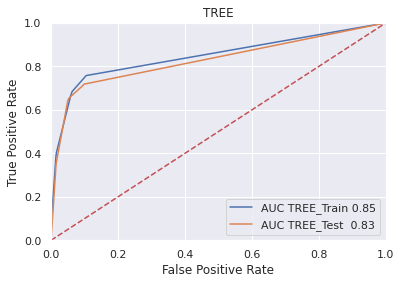

In [66]:
# ROC CURVE (BEST PRACTICE)

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 

#### Display the Decision Tree using a Graphviz program


In [67]:
#@title
# ORIGINAL CODE

# feature_cols = list( X.columns.values )

# tree.export_graphviz(fm01_Tree,out_file='tree_f.txt',filled=True, rounded=True, 
#                      feature_names = feature_cols, impurity=False, 
#                      class_names=["Good","Bad"]  )

In [68]:
feature_cols = list( X.columns.values )

tree.export_graphviz(CLM,out_file='tree_f.txt',filled=True, rounded=True, 
                     feature_names = feature_cols, impurity=False, 
                     class_names=["Good","Bad"]  )

After running this code, I used the online viewer at http://graphviz.it/ to create the following GraphViz visualization of my 3-Level Decision Tree:

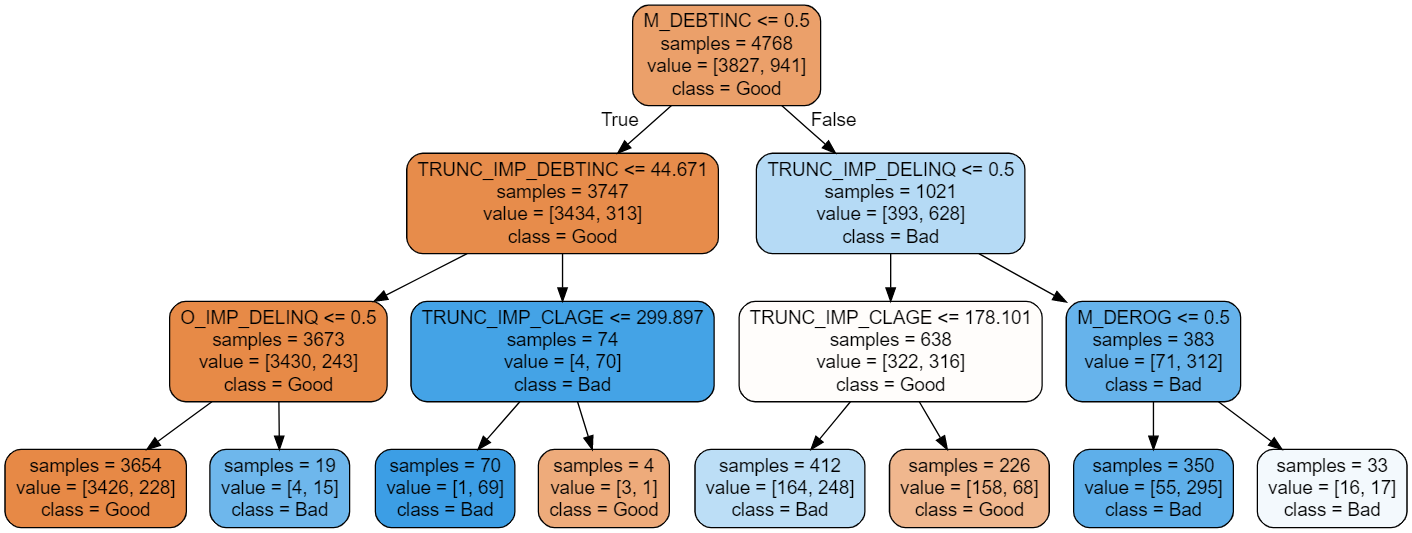

#### List the variables included in the decision tree that predict loan default.

* **After calculating these variables, we store them for future reference in `vars_tree_flag`.**

In [69]:
#@title
# ORIGINAL CODE 

# vars_tree_flag = getTreeVars( CLM, feature_cols ) 
# vars_tree_flag

In [70]:
'''
Pro Tip: When collecting variable names from decision trees,
run the model several different times using different random_state values
'''

vars_tree_flag = getTreeVars( CLM, feature_cols ) 
vars_tree_flag

['M_VALUE',
 'M_DEROG',
 'M_DEBTINC',
 'TRUNC_IMP_DELINQ',
 'TRUNC_IMP_CLAGE',
 'TRUNC_IMP_DEBTINC']

### **Develop a decision tree to predict the loss amount assuming that the loan defaults**


#### Calculate the RMSE for both the training data set and the test data set

We now build a Decision Tree ML model for the continuous target variable (the predicted monetary value of a default):

* The `amt_m01_Tree` object establishes the type of model to be used -- in this case a decision tree `tree.DecisionTreeClassifier()`, and specifying the fit data using `.fit()`. These functions are imported from the `sklearn` package.

* **Note: For continuous target variable model fitting, I must remember to use the subsets `W`, `Z` (which do not include the NaN values)**

* Once the parameters have been set the `.predict()` function creates a prediction DataFrame for both train and test.

* Since the values of the target variables are actually known for both `Z_train` and `Z_test` the accuracy of the model can be determined as a Root Mean Square Error (RMSE) value, which is the standard deviation of the residuals (prediction errors), by using the `.mean_squared_error()` function (from the `sklearn.metrics` package).

* **After calculating these metrics, we store them for future analysis in `RMSE_TREE`.**


In [71]:
#@title

# VALUE OF LOAN DEFAULT ORIGINAL CODE

'''
For continuous target variable model fitting, 
Remember to use the subset W, Z (which does not include the NaN values)
'''

# #amt_m01_Tree = tree.DecisionTreeRegressor()
# amt_m01_Tree = tree.DecisionTreeRegressor( max_depth= 3 )
# amt_m01_Tree = amt_m01_Tree.fit( W_train, Z_train[TARGET_A] )

# Z_Pred_train = amt_m01_Tree.predict(W_train)
# Z_Pred_test = amt_m01_Tree.predict(W_test)

# print( "MEAN Train", Z_train[TARGET_A].mean() )
# print( "MEAN Test", Z_test[TARGET_A].mean() )
# print( " ----- \n\n" )

# RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_A], Z_Pred_train))
# RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_A], Z_Pred_test))

# print("TREE RMSE Train:", RMSE_TRAIN )
# print("TREE RMSE Test:", RMSE_TEST )

# RMSE_TREE = RMSE_TEST


'\nFor continuous target variable model fitting, \nRemember to use the subset W, Z (which does not include the NaN values)\n'

In [72]:
# VALUE OF LOAN DEFAULT (BEST PRACTICE)

'''
For continuous target variable model fitting, 
Remember to use the subset W, Z (which does not include the NaN values)
'''

#AMT = tree.DecisionTreeRegressor( max_depth= 4 )
AMT = tree.DecisionTreeRegressor( max_depth= 4, min_samples_leaf = 15 )
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO + "_Test ", AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TREE RMSE ACCURACY
TREE_Train  =  5042.703704996518
TREE_Test   =  6461.242833559236
------




#### Display the Decision Tree using a Graphviz program


In [73]:
feature_cols = list( X.columns.values )
tree.export_graphviz(AMT,out_file='tree_a.txt',filled=True, rounded=True, 
                     feature_names = feature_cols, impurity=False, precision=0  )


After running this code, I used the online viewer at http://graphviz.it/ to create the following GraphViz visualization of my 3-Level Decision Tree for predicted the Loan Default Value:

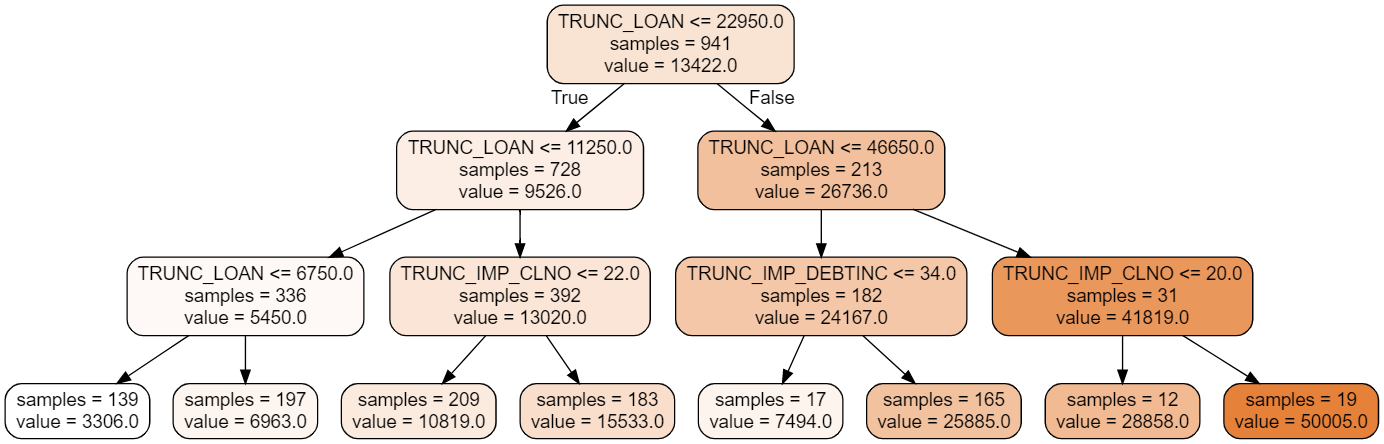

#### List the variables included in the decision tree that predict loss amount.

* **After calculating these variables, we store them for future reference in `vars_tree_amt`.**


In [74]:
vars_tree_amt = getTreeVars( AMT, feature_cols ) 
print("\n")
for i in vars_tree_amt :
    print(i)

#print( "FLAG=",vars_tree_flag )
#print(" ==== \n\n")
#print( "AMOUNT=",vars_tree_amt )

TREE_CLM = TEST_CLM.copy()
TREE_AMT = TEST_AMT.copy()



M_DEBTINC
TRUNC_IMP_CLNO
TRUNC_LOAN
TRUNC_IMP_DEBTINC


## ***Random Forests:***



### **Develop a Random Forest to predict the probability of default**


#### Calculate the accuracy of the model on both the training and test data set

This is the same Python code as the Decision Tree ML Model above, except now we are using `RandomForestClassifier()`, imported from `sklearn.ensemble`.

With `RandomForestClassifier()`:

* `n_estimators` provides the total number of Decision Trees that are utilized in the Random Forest ML Model
* By setting the `random_state` input to equal `1` we can create repeatable results and statistics as we analyze different models.

In [75]:
#@title
"""
RANDOM FOREST
"""

# #fm01_RF = RandomForestClassifier()
# #fm01_RF = RandomForestClassifier( n_estimators = 5, random_state=1 )
# fm01_RF = RandomForestClassifier(max_depth = 6, n_estimators = 65, random_state=1 )
# fm01_RF = fm01_RF.fit( X_train, Y_train[ TARGET_F ] )

# Y_Pred_train = fm01_RF.predict(X_train)
# Y_Pred_test = fm01_RF.predict(X_test)

# print("\n=============\n")
# print("RANDOM FOREST\n")
# print("Probability of loan default")
# print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
# print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))
# print("\n")

'\nRANDOM FOREST\n'

In [76]:
"""
RANDOM FOREST (BEST PRACTICE)
"""

WHO = "RF"

# CLM = RandomForestClassifier(max_depth = 6, n_estimators = 65, random_state=1 )
CLM = RandomForestClassifier(max_depth = 6,
                             n_estimators = 100, 
                             max_features = "sqrt",
                             random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO + "_Test ", CLM, X_test, Y_test[ TARGET_F ] )

print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

RF CLASSIFICATION ACCURACY
RF_Train  =  0.8995385906040269
RF_Test   =  0.8808724832214765
------




#### Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.

This is the same Python code as the Decision Tree ML Model above, except:

* **After calculating these metrics, we store them for future analysis in `fpr_RF`, `tpr_RF`, and `auc_RF`.**


In [77]:
#@title
# ROC CURVE ORIGINAL CODE

# probs = fm01_RF.predict_proba(X_train)
# p1 = probs[:,1]
# fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_F], p1)
# roc_auc_train = metrics.auc(fpr_train, tpr_train)

# probs = fm01_RF.predict_proba(X_test)
# p1 = probs[:,1]
# fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_F], p1)
# roc_auc_test = metrics.auc(fpr_test, tpr_test)

# fpr_RF = fpr_test
# tpr_RF = tpr_test
# auc_RF = roc_auc_test

# plt.title('RF ROC CURVE')
# plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
# plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

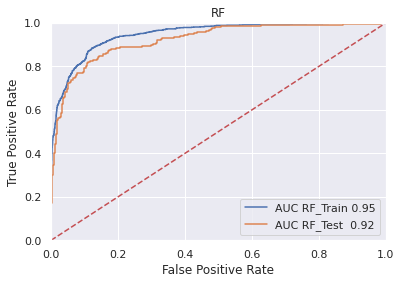

In [78]:
# ROC CURVE (BEST PRACTICE)

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 

#### List the variables included in the Random Forest that predict loan default.

* **After calculating these variables, we store them for future reference in `vars_RF_flag`.**

In [79]:
feature_cols = list( X.columns.values )
vars_RF_flag = getEnsembleTreeVars( CLM, feature_cols )

for i in vars_RF_flag :
    print( i )

('M_DEBTINC', 100)
('TRUNC_IMP_DEBTINC', 62)
('TRUNC_IMP_DELINQ', 37)
('TRUNC_IMP_DEROG', 21)
('M_VALUE', 18)
('TRUNC_IMP_CLAGE', 15)
('TRUNC_LOAN', 14)


### **Develop a Random Forest to predict the loss amount assuming that the loan defaults**


#### Calculate the RMSE for both the training data set and the test data set

This is the same Python code as the Decision Tree ML Model above, except now we are using `RandomForestRegressor()`, imported from `sklearn.ensemble`.

With `RandomForestRegressor()`:

* `n_estimators` provides the total number of Decision Trees that are utilized in the Random Forest ML Model
* By setting the `random_state` input to equal `1` we can create repeatable results and statistics as we analyze different models.

* **After calculating these metrics, we store them for future analysis in `RMSE_RF`.**

In [80]:
#@title
# VALUE OF LOAN DEFAULT ORIGINAL CODE

# '''
# For continuous target variable model fitting, 
# Remember to use the subset W, Z (which does not include the NaN values)
# '''

# amt_m01_RF = RandomForestRegressor(random_state = 1)
# #amt_m01_RF = RandomForestRegressor(n_estimators = 5, random_state=1)
# amt_m01_RF = amt_m01_RF.fit( W_train, Z_train[TARGET_A] )

# Z_Pred_train = amt_m01_RF.predict(W_train)
# Z_Pred_test = amt_m01_RF.predict(W_test)

# print( "MEAN Train", Z_train[TARGET_A].mean() )
# print( "MEAN Test", Z_test[TARGET_A].mean() )
# print( " ----- \n\n" )

# RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_A], Z_Pred_train))
# RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_A], Z_Pred_test))

# print("RF RMSE Train:", RMSE_TRAIN )
# print("RF RMSE Test:", RMSE_TEST )

# RMSE_RF = RMSE_TEST

In [81]:
# VALUE OF LOAN DEFAULT (BEST PRACTICE)

'''
For continuous target variable model fitting, 
Remember to use the subset W, Z (which does not include the NaN values)
'''

# AMT = RandomForestRegressor(random_state=1)
AMT = RandomForestRegressor(max_depth = 4,
                            n_estimators = 100, 
                            max_features = None,
                            random_state=1 )
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO + "_Test ", AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

RF RMSE ACCURACY
RF_Train  =  3679.8236808790834
RF_Test   =  4842.274906367334
------




#### List the variables included in the Random Forest that predict loss amount.

* **After calculating these variables, we store them for future reference in `vars_RF_amt`.**

In [82]:
feature_cols = list( X.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

for i in vars_RF_amt :
    print( i )

RF_CLM = TEST_CLM.copy()
RF_AMT = TEST_AMT.copy()

('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 10)
('TRUNC_IMP_DEBTINC', 4)


## ***Gradient Boosting:***



### **Develop a Gradient Boosting model to predict the probability of default**


#### Calculate the accuracy of the model on both the training and test data set

This is the same Python code as the Decision Tree ML Model above, except now we are using `GradientBoostingClassifier()`, imported from `sklearn.ensemble`.

With `GradientBoostingClassifier()`:

* By setting the `random_state` input to equal `1` we can create repeatable results and statistics as we analyze different models.

In [83]:
#@title
"""
GRADIENT BOOSTING ORIGINAL CODE
"""

# #fm01_GB = GradientBoostingClassifier()
# fm01_GB = GradientBoostingClassifier( random_state=1 )
# #fm01_GB = GradientBoostingClassifier(n_estimators = 5, learning_rate=0.1, random_state=1 )
# fm01_GB = fm01_GB.fit( X_train, Y_train[ TARGET_F ] )

# Y_Pred_train = fm01_GB.predict(X_train)
# Y_Pred_test = fm01_GB.predict(X_test)

# print("\n=============\n")
# print("GRADIENT BOOSTING\n")
# print("Probability of crash")
# print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
# print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))
# print("\n")


'\nGRADIENT BOOSTING ORIGINAL CODE\n'

In [84]:
"""
GRADIENT BOOSTING (BEST PRACTICE)
"""

WHO = "GB"

# CLM = GradientBoostingClassifier()
CLM = GradientBoostingClassifier( random_state=1 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO + "_Test ", CLM, X_test, Y_test[ TARGET_F ] )

print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

GB CLASSIFICATION ACCURACY
GB_Train  =  0.923238255033557
GB_Test   =  0.9068791946308725
------




#### Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.

This is the same Python code as the Decision Tree ML Model above, except:

* **After calculating these metrics, we store them for future analysis in `fpr_GB`, `tpr_GB`, and `auc_GB`.**

In [85]:
#@title
# ROC CURVE ORIGINAL CODE

# probs = fm01_GB.predict_proba(X_train)
# p1 = probs[:,1]
# fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_F], p1)
# roc_auc_train = metrics.auc(fpr_train, tpr_train)

# probs = fm01_GB.predict_proba(X_test)
# p1 = probs[:,1]
# fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_F], p1)
# roc_auc_test = metrics.auc(fpr_test, tpr_test)

# fpr_GB = fpr_test
# tpr_GB = tpr_test
# auc_GB = roc_auc_test

# plt.title('GB ROC CURVE')
# plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
# plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color="red")
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

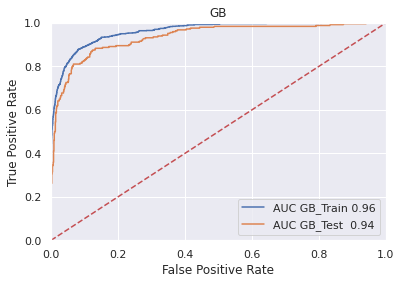

In [86]:
# ROC CURVE (BEST PRACTICE)

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 

#### List the variables included in the Gradient Boosting that predict loan default.

* **After calculating these variables, we store them for future reference in `vars_GB_flag`.**

In [87]:
feature_cols = list( X.columns.values )
vars_GB_flag = getEnsembleTreeVars( CLM, feature_cols )


for i in vars_GB_flag :
    print(i)

('M_DEBTINC', 100)
('TRUNC_IMP_DEBTINC', 29)
('TRUNC_IMP_DELINQ', 18)
('TRUNC_IMP_CLAGE', 14)
('TRUNC_IMP_DEROG', 7)
('M_VALUE', 7)


### **Develop a Gradient Boosting to predict the loss amount assuming that the loan defaults**


#### Calculate the RMSE for both the training data set and the test data set

This is the same Python code as the Decision Tree ML Model above, except now we are using `GradientBoostingRegressor()`, imported from `sklearn.ensemble`.

With `GradientBoostingRegressor()`:

* `n_estimators` provides the number of weak learners (i.e. regression trees) 
* By setting the `random_state` input to equal `1` we can create repeatable results and statistics as we analyze different models.

* **After calculating these metrics, we store them for future analysis in `RMSE_GB`.**


In [88]:
#@title
# VALUE OF LOAN DEFAULT ORIGINAL CODE

# '''
# For continuous target variable model fitting, 
# Remember to use the subset W, Z (which does not include the NaN values)
# '''
# #amt_m01_GB = GradientBoostingRegressor()
# amt_m01_GB = GradientBoostingRegressor(random_state=1, )
# #amt_m01_GB = GradientBoostingRegressor(n_estimators = 5, learning_rate=0.1, random_state=1, )
# amt_m01_GB = amt_m01_GB.fit( W_train, Z_train[TARGET_A] )

# Z_Pred_train = amt_m01_GB.predict(W_train)
# Z_Pred_test = amt_m01_GB.predict(W_test)

# print( "MEAN Train", Z_train[TARGET_A].mean() )
# print( "MEAN Test", Z_test[TARGET_A].mean() )
# print( " ----- \n\n" )

# RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_A], Z_Pred_train))
# RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_A], Z_Pred_test))

# print("GB RMSE Train:", RMSE_TRAIN )
# print("GB RMSE Test:", RMSE_TEST )

# RMSE_GB = RMSE_TEST

In [89]:
# VALUE OF LOAN DEFAULT (BEST PRACTICE)

'''
For continuous target variable model fitting, 
Remember to use the subset W, Z (which does not include the NaN values)
'''

AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO + "_Test ", AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

GB RMSE ACCURACY
GB_Train  =  1271.992729624835
GB_Test   =  2658.6822153725543
------




#### List the variables included in the Gradient Boosting that predict loss amount.

* **After calculating these variables, we store them for future reference in `vars_GB_amt`.**


In [90]:
feature_cols = list( X.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )

for i in vars_GB_amt :
    print(i)

GB_CLM = TEST_CLM.copy()
GB_AMT = TEST_AMT.copy()

('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 14)
('TRUNC_IMP_DEBTINC', 6)
('M_DEBTINC', 5)
('TRUNC_IMP_CLAGE', 4)


## Pre-Process the Data Set:


### See above
Steps 1 through 7 address the data preparation that must occur immediately prior to creating the training and test data sets, summarized below:

* Step 1: Download the HMEQ Data set
* Step 2: Read the data into Python
* Step 3: Explore both the input and target variables using statistical techniques
* Step 4: Explore both the input and target variables using graphs and other visualization.
* Step 5: Look for relationships between the input variables and the targets.
* Step 6: Fix (impute) all missing data.
* Step 7: Convert all categorical variables into numeric variables (One Hot Encoding)


## Create a Training and Test Data Set

See above, which addresses Creating a Training and Test Data Set 


## ***Logistic Regression:***


### Develop a logistic regression model to determine the probability of a loan default. Use all of the variables.

* Calculate the accuracy of the model on both the training and test data set

* Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.

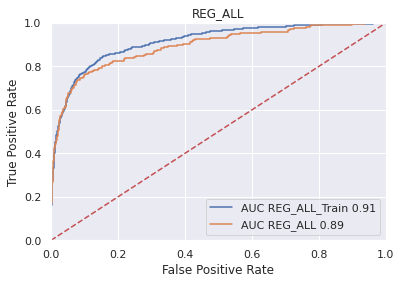

REG_ALL CLASSIFICATION ACCURACY
REG_ALL_Train  =  0.8894714765100671
REG_ALL  =  0.8884228187919463
------


29

DEFAULT
---------
Total Variables:  30
INTERCEPT  =  -5.276881575598936
M_MORTDUE  =  0.26992382767295725
M_VALUE  =  3.87745808031457
M_YOJ  =  -0.6680842643023275
M_DEROG  =  -1.7369176623466063
M_DELINQ  =  -0.21501408296587785
M_CLAGE  =  1.1148088759583876
M_NINQ  =  0.054776240529935315
M_CLNO  =  2.0126202473259647
M_DEBTINC  =  2.643641777560527
z_IMP_REASON_DebtCon  =  -0.1518421033170932
z_IMP_REASON_HomeImp  =  0.020817689778021918
z_IMP_REASON_MISSING  =  -0.05134467166773295
z_IMP_JOB_MISSING  =  -1.422894002565791
z_IMP_JOB_Mgr  =  0.06843932249066935
z_IMP_JOB_Office  =  -0.5442695782186859
z_IMP_JOB_Other  =  0.15894181749851738
z_IMP_JOB_ProfExe  =  -0.06390453441497429
z_IMP_JOB_Sales  =  1.2559784137732373
z_IMP_JOB_Self  =  0.3653394762302273
TRUNC_LOAN  =  -9.953127433750465e-07
TRUNC_IMP_MORTDUE  =  -1.292827107651915e-06
TRUNC_IMP_VALUE  =  1.422393997

In [91]:
"""
REGRESSION ALL VARIABLES
"""

WHO = "REG_ALL"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

varNames = list( X_train.columns.values )
print(len(varNames))

REG_ALL_CLM_COEF = getCoefLogit( CLM, X_train )

REG_ALL_CLM = TEST_CLM.copy()

### Develop a logistic regression model to determine the probability of a loan default. Use the variables that were selected by a DECISION TREE.

* Calculate the accuracy of the model on both the training and test data set

* Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.

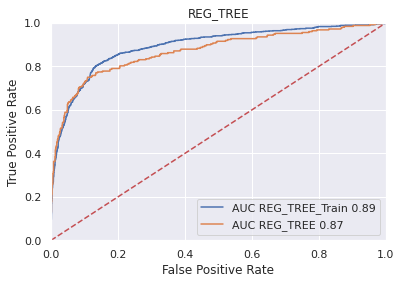

REG_TREE CLASSIFICATION ACCURACY
REG_TREE_Train  =  0.8783557046979866
REG_TREE  =  0.87751677852349
------


29

DEFAULT
---------
Total Variables:  7
INTERCEPT  =  -5.251106767719212
M_VALUE  =  3.7515145246815336
M_DEROG  =  -1.0088243570423134
M_DEBTINC  =  2.7765720426699283
TRUNC_IMP_DELINQ  =  0.7707083600231709
TRUNC_IMP_CLAGE  =  -0.00699157545232241
TRUNC_IMP_DEBTINC  =  0.10460254170212302


In [92]:
"""
REGRESSION DECISION TREE
"""

WHO = "REG_TREE"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[vars_tree_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[vars_tree_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[vars_tree_flag], Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

varNames = list( X_train.columns.values )
print(len(varNames))

REG_TREE_CLM_COEF = getCoefLogit( CLM, X_train[vars_tree_flag] )

REG_TREE_CLM = TEST_CLM.copy()

### Develop a logistic regression model to determine the probability of a loan default. Use the variables that were selected by a RANDOM FOREST.

* Calculate the accuracy of the model on both the training and test data set

* Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.




('M_DEBTINC', 100)
('TRUNC_IMP_DEBTINC', 62)
('TRUNC_IMP_DELINQ', 37)
('TRUNC_IMP_DEROG', 21)
('M_VALUE', 18)
('TRUNC_IMP_CLAGE', 15)
('TRUNC_LOAN', 14)


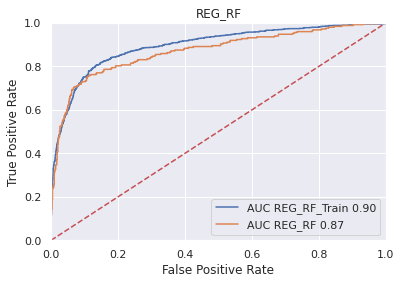

REG_RF CLASSIFICATION ACCURACY
REG_RF_Train  =  0.8800335570469798
REG_RF  =  0.8783557046979866
------



DEFAULT
---------
Total Variables:  8
INTERCEPT  =  -5.408054010923215
M_DEBTINC  =  2.730372860657705
TRUNC_IMP_DEBTINC  =  0.10401564970152574
TRUNC_IMP_DELINQ  =  0.6736028446059611
TRUNC_IMP_DEROG  =  0.7537980620251906
M_VALUE  =  3.54541245911008
TRUNC_IMP_CLAGE  =  -0.006822555470224353
TRUNC_LOAN  =  -4.301096531632297e-06


In [93]:
"""
REGRESSION RANDOM FOREST
"""

WHO = "REG_RF"

print("\n\n")
RF_flag = []
for i in vars_RF_flag :
    print(i)
    theVar = i[0]
    RF_flag.append( theVar )

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[RF_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[RF_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[RF_flag], Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

REG_RF_CLM_COEF = getCoefLogit( CLM, X_train[RF_flag] )

REG_RF_CLM = TEST_CLM.copy()

### Develop a logistic regression model to determine the probability of a loan default. Use the variables that were selected by a GRADIENT BOOSTING model.

* Calculate the accuracy of the model on both the training and test data set

* Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.




('M_DEBTINC', 100)
('TRUNC_IMP_DEBTINC', 29)
('TRUNC_IMP_DELINQ', 18)
('TRUNC_IMP_CLAGE', 14)
('TRUNC_IMP_DEROG', 7)
('M_VALUE', 7)


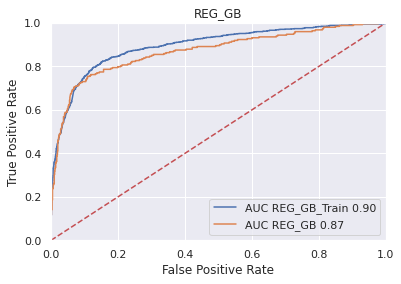

REG_GB CLASSIFICATION ACCURACY
REG_GB_Train  =  0.881501677852349
REG_GB  =  0.8800335570469798
------



DEFAULT
---------
Total Variables:  7
INTERCEPT  =  -5.459335531881548
M_DEBTINC  =  2.741783842373928
TRUNC_IMP_DEBTINC  =  0.10355245672355406
TRUNC_IMP_DELINQ  =  0.6771423231188963
TRUNC_IMP_CLAGE  =  -0.006905707257670997
TRUNC_IMP_DEROG  =  0.7499390342200059
M_VALUE  =  3.5351671523206316


In [94]:
"""
REGRESSION GRADIENT BOOSTING
"""

WHO = "REG_GB"

print("\n\n")
GB_flag = []
for i in vars_GB_flag :
    print(i)
    theVar = i[0]
    GB_flag.append( theVar )

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[GB_flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[GB_flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[GB_flag], Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

REG_GB_CLM_COEF = getCoefLogit( CLM, X_train[GB_flag] )

REG_GB_CLM = TEST_CLM.copy()

### Develop a logistic regression model to determine the probability of a loan default. Use the variables that were selected by STEPWISE SELECTION.

* Calculate the accuracy of the model on both the training and test data set

* Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.

As determined in the Section below, there appears to be a short list of variables which are repeatedly showing up in models, so I create this designated "short list" called `short` in order to analysis a Stepwise Selection of variables.

In [95]:
short = ['M_VALUE', 'M_DEROG', 'M_DEBTINC', 'TRUNC_LOAN', 'TRUNC_IMP_MORTDUE', 
         'TRUNC_IMP_VALUE', 'TRUNC_IMP_YOJ', 'TRUNC_IMP_DEROG', 
         'TRUNC_IMP_DELINQ', 'TRUNC_IMP_CLAGE', 'TRUNC_IMP_NINQ', 
         'TRUNC_IMP_CLNO', 'TRUNC_IMP_DEBTINC']

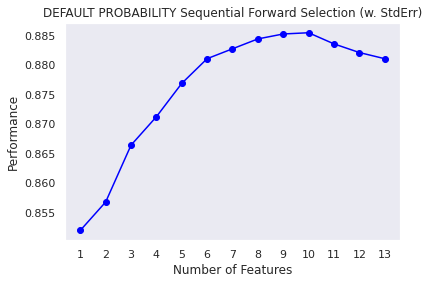

 ................... 
argmax
feature_names    (0, 1, 2, 3, 5, 7, 8, 9, 10, 12)
avg_score                                0.885487
Name: 10, dtype: object
 ................... 
('0', '1', '2', '3', '5', '7', '8', '9', '10', '12')
M_VALUE
M_DEROG
M_DEBTINC
TRUNC_LOAN
TRUNC_IMP_VALUE
TRUNC_IMP_DEROG
TRUNC_IMP_DELINQ
TRUNC_IMP_CLAGE
TRUNC_IMP_NINQ
TRUNC_IMP_DEBTINC


In [96]:
"""
REGRESSION STEPWISE
"""

#U_train = X_train # This takes a LONG time
U_train = X_train[ short ]
stepVarNames = list( U_train.columns.values )
maxCols = U_train.shape[1]

sfs = SFS( LogisticRegression( solver='newton-cg', max_iter=100 ),
           k_features=( 1, maxCols ),
           forward=True,
           floating=False,
           cv=3
           )
sfs.fit(U_train.values, Y_train[ TARGET_F ].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('DEFAULT PROBABILITY Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

U_train = X_train[ finalStepVars ]
U_test = X_test[ finalStepVars ]

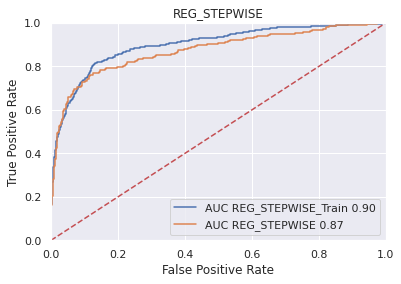

REG_STEPWISE CLASSIFICATION ACCURACY
REG_STEPWISE_Train  =  0.8835989932885906
REG_STEPWISE  =  0.886744966442953
------



DEFAULT
---------
Total Variables:  11
INTERCEPT  =  -5.345510731294926
M_VALUE  =  3.7592143785058827
M_DEROG  =  -0.8410395250795859
M_DEBTINC  =  2.688444285432697
TRUNC_LOAN  =  -7.801393130856213e-06
TRUNC_IMP_VALUE  =  -2.1138700281315456e-08
TRUNC_IMP_DEROG  =  0.6588320025584373
TRUNC_IMP_DELINQ  =  0.6980126589561987
TRUNC_IMP_CLAGE  =  -0.006491296758389009
TRUNC_IMP_NINQ  =  0.13183443038150935
TRUNC_IMP_DEBTINC  =  0.10091460001020232


In [97]:
"""
REGRESSION 
"""

WHO = "REG_STEPWISE"

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( U_train, Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

REG_STEP_CLM_COEF = getCoefLogit( CLM, U_train )

REG_STEP_CLM = TEST_CLM.copy()

### Develop a logistic regression model to determine the probability of a loan default. Use the variables that were selected by model.

* Calculate the accuracy of the model on both the training and test data set

* Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.

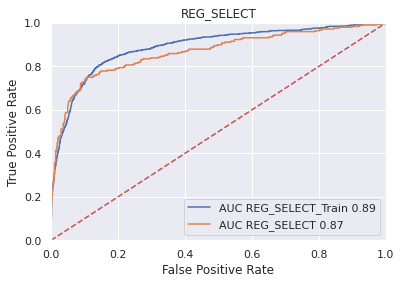

REG_SELECT CLASSIFICATION ACCURACY
REG_SELECT_Train  =  0.8733221476510067
REG_SELECT  =  0.8800335570469798
------



DEFAULT
---------
Total Variables:  6
INTERCEPT  =  -5.319093302859722
M_VALUE  =  3.517323923509867
M_DEBTINC  =  2.774846738734137
TRUNC_IMP_DELINQ  =  0.7435149050949961
TRUNC_IMP_CLAGE  =  -0.007158620677206144
TRUNC_IMP_DEBTINC  =  0.10479987406303559


In [98]:
"""
REGRESSION
"""

WHO = "REG_SELECT"

Select_Flag = ['M_VALUE', 'M_DEBTINC', 'TRUNC_IMP_DELINQ', 
               'TRUNC_IMP_CLAGE', 'TRUNC_IMP_DEBTINC']

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[Select_Flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[Select_Flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[Select_Flag], Y_test[ TARGET_F ] )

print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

REG_SEL_CLM_COEF = getCoefLogit( CLM, X_train[Select_Flag] )

REG_SEL_CLM = TEST_CLM.copy()

### Display a ROC curve for the test data with all your models on the same graph (tree based and regression).


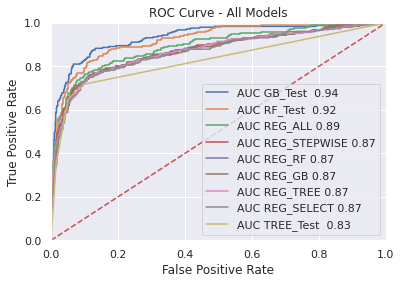

ALL CLASSIFICATION ACCURACY
GB_Test   =  0.9068791946308725
REG_ALL  =  0.8884228187919463
REG_STEPWISE  =  0.886744966442953
TREE_Test   =  0.8859060402684564
RF_Test   =  0.8808724832214765
REG_GB  =  0.8800335570469798
REG_SELECT  =  0.8800335570469798
REG_RF  =  0.8783557046979866
REG_TREE  =  0.87751677852349
------




In [99]:
ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM, REG_GB_CLM, REG_STEP_CLM, REG_SEL_CLM ]

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( "ROC Curve - All Models", ALL_CLM ) 

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )

---
**NOTES:** 

* Results with `O_` variables included:

| Model | AUC |
| --- | --- |
| Gradient Boosting | 0.94 |
| Random Forest | 0.91 |
| Logistic Regression (All Vars) | 0.90 |
| Logistic Regression (Stepwise Vars) | 0.87 |
| Logistic Regression (RF Vars) | 0.87 |
| Logistic Regression (GB Vars) | 0.87 |
| Logistic Regression (Tree Vars) | 0.87 | 
| Logistic Regression (Bonus Bingo Vars) | 0.87 |
| Decision Trees | 0.83 |
| --- | --- |

| Model | Accuracy |
| --- | --- |
| Gradient Boosting | 0.9060402684563759 |
| Logistic Regression (All Vars) | 0.886744966442953 |
| Logistic Regression (Stepwise Vars) | 0.886744966442953 |
| Decision Trees | 0.8825503355704698 |
| Logistic Regression (RF Vars) | 0.8817114093959731 |
| Logistic Regression (GB Vars) | 0.8800335570469798 |
| Logistic Regression (Bonus Bingo Vars) | 0.8800335570469798 |
| Random Forest | 0.8783557046979866 |
| Logistic Regression (Tree Vars) | 0.8733221476510067 |


* Results with `O_` variables excluded:

| Model | AUC |
| --- | --- |
| Gradient Boosting | 0.94 |
| Random Forest | 0.92 |
| Logistic Regression (All Vars) | 0.89 |
| Logistic Regression (Stepwise Vars) | 0.87 |
| Logistic Regression (GB Vars) | 0.87 |
| Logistic Regression (RF Vars) | 0.87 |
| Logistic Regression (Bonus Bingo Vars) | 0.87 |
| Logistic Regression (Tree Vars) | 0.87 | 
| Decision Trees | 0.83 |
| --- | --- |

| Model | Accuracy |
| --- | --- |
| Gradient Boosting | 0.9068791946308725 |
| Logistic Regression (All Vars) | 0.8884228187919463 |
| Logistic Regression (Stepwise Vars) | 0.886744966442953 |
| Decision Trees | 0.8859060402684564 |
| Random Forest | 0.8808724832214765 |
| Logistic Regression (GB Vars) | 0.8800335570469798 |
| Logistic Regression (Bonus Bingo Vars) | 0.8800335570469798 |
| Logistic Regression (RF Vars) | 0.8783557046979866 |
| Logistic Regression (Tree Vars) | 0.87751677852349 |

---

**Conclusion: Omit the `O_` Variables, since they do not have an appreciable effect on the model AUC or Accuracy.

### Discuss which one is the most accurate. Which one would you recommend using?

For predicting the ***probability*** of a loan default (the classification model) the most accurate model remains the **Gradient Boosting Model.** If legal or ethical issues are not in play, then I would continue to recommend deploying the **Gradient Boosting Model** into production, because it performs the best out of all of these models. In addition the number of variables is relatively low for deploying these models so there is not much of a tradeoff associated with either speed or complexity.

There may be some legal or ethical issues associated with deploying the Gradient Boosting model in a commercial sense and then using this type of model to "reject" loan applicants, because it is not easy to determine exactly which variables are contributing the predictions.

If legal or ethical issues arise, OR if there are concerns with the difficulty of placing a Gradient Boosting Model into production, then as a completely acceptable alternative, the accuracy and AUC values of the **Logistic Regression Model (using Stepwise-determined Variables)** may provide the best path forward. This alternative only leads to a 7% decrease in AUC and a 

### For one of the Regression Models, print the coefficients. Do the variables make sense? If not, what would you recommend?


In [100]:

"""
REGRESSION
"""

WHO = "REG_SELECT"

Select_Flag = ['M_VALUE', 'M_DEBTINC', 'TRUNC_IMP_DELINQ', 
               'TRUNC_IMP_CLAGE', 'TRUNC_IMP_DEBTINC']

CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
CLM = CLM.fit( X_train[Select_Flag], Y_train[ TARGET_F ] )

TRAIN_CLM = getProbAccuracyScores( WHO + "_Train", CLM, X_train[Select_Flag], Y_train[ TARGET_F ] )
TEST_CLM = getProbAccuracyScores( WHO, CLM, X_test[Select_Flag], Y_test[ TARGET_F ] )

#print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 
#print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

REG_SEL_CLM_COEF = getCoefLogit( CLM, X_train[Select_Flag] )

#REG_SEL_CLM = TEST_CLM.copy()


DEFAULT
---------
Total Variables:  6
INTERCEPT  =  -5.319093302859722
M_VALUE  =  3.517323923509867
M_DEBTINC  =  2.774846738734137
TRUNC_IMP_DELINQ  =  0.7435149050949961
TRUNC_IMP_CLAGE  =  -0.007158620677206144
TRUNC_IMP_DEBTINC  =  0.10479987406303559


The goal of the Logistic Regression will be to determine the probability of default, which will be value ranging between 0 and 1. Here is a sypnopsis of these variables:

* 'INTERCEPT`: The intercept implies that all (except 1) of the variables ADD to the probability of experiencing a loan default. So, in order to have a final estimate that is between 0 and 1, the starting point for the estimate must be less than zero. This makes sense that the variable is -5.32.
* `M_VALUE`: If the Home Value is missing from the loan application, then this `ADD 3.527` to the likelihood of default. This makes sense, as it is likely that if you owe a lot of money on your current mortgage versus the value of your house, you are more risky. So if you intentionally omit this information, it is likely you are trying to hide this (and are a higher risk).
* `M_DEBTINC`: If the Home Value is missing from the loan application, then this `ADD 2.775` to the likelihood of default. This makes sense, as it is likely that if you have a high debt to income ratio, you are more risky. So if you intentionally omit this information, it is likely you are trying to hide this (and are a higher risk).
* `TRUNC_IMP_DELINQ`: Each delinquency on your current credit report `ADD 0.744` to the probability of default. This makes sense as previous delinquencies means higher risk.
* `TRUNC_IMP_CLAGE`: This is the only negative correlated variable, meaning the for each month of credit line age, `REDUCE 0.007` from the probability of default. This make sense as older people with longer credit history are likely to have lower rates of default.
* `TRUNC_IMP_DEBTINC`: As debt to income ratio increases, there is a higher likelihood of default. This makes sense.

## ***Linear Regression:***


### Develop a linear regression model to determine the expected loss if the loan defaults. Use all of the variables.

* Calculate the RMSE for both the training data set and the test data set

In [101]:
# VALUE OF LOAN DEFAULT

WHO = "REG_ALL"

AMT = LinearRegression()
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

varNames = list( X_train.columns.values )
print(varNames)

REG_ALL_AMT_COEF = getCoefLinear( AMT, X_train )

REG_ALL_AMT = TEST_AMT.copy()

REG_ALL RMSE ACCURACY
REG_ALL_Train  =  3764.0361719195257
REG_ALL  =  4368.004791973564
------


['M_MORTDUE', 'M_VALUE', 'M_YOJ', 'M_DEROG', 'M_DELINQ', 'M_CLAGE', 'M_NINQ', 'M_CLNO', 'M_DEBTINC', 'z_IMP_REASON_DebtCon', 'z_IMP_REASON_HomeImp', 'z_IMP_REASON_MISSING', 'z_IMP_JOB_MISSING', 'z_IMP_JOB_Mgr', 'z_IMP_JOB_Office', 'z_IMP_JOB_Other', 'z_IMP_JOB_ProfExe', 'z_IMP_JOB_Sales', 'z_IMP_JOB_Self', 'TRUNC_LOAN', 'TRUNC_IMP_MORTDUE', 'TRUNC_IMP_VALUE', 'TRUNC_IMP_YOJ', 'TRUNC_IMP_DEROG', 'TRUNC_IMP_DELINQ', 'TRUNC_IMP_CLAGE', 'TRUNC_IMP_NINQ', 'TRUNC_IMP_CLNO', 'TRUNC_IMP_DEBTINC']

VALUE OF LOAN DEFAULT
---------
Total Variables:  30
INTERCEPT  =  -13003.130914371188
M_MORTDUE  =  -434.7299130982653
M_VALUE  =  154.26686030558918
M_YOJ  =  -234.08361842768372
M_DEROG  =  800.4807370410201
M_DELINQ  =  1181.5945972167026
M_CLAGE  =  -4951.500893690586
M_NINQ  =  -1462.5308719792476
M_CLNO  =  6853.585163504471
M_DEBTINC  =  5612.972578721244
z_IMP_REASON_DebtCon  =  1106.38501650234

### Develop a linear regression model to determine the expected loss if the loan defaults. Use the variables that were selected by a DECISION TREE.


* Calculate the RMSE for both the training data set and the test data set

In [102]:
# VALUE OF LOAN DEFAULT

WHO = "REG_TREE"

AMT = LinearRegression()
AMT = AMT.fit( W_train[vars_tree_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[vars_tree_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[vars_tree_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

varNames = list( X_train.columns.values )
print(len(varNames))

REG_TREE_AMT_COEF = getCoefLinear( AMT, X_train[vars_tree_amt] )

REG_TREE_AMT = TEST_AMT.copy()


REG_TREE RMSE ACCURACY
REG_TREE_Train  =  4579.240752397916
REG_TREE  =  5173.498532555318
------


29

VALUE OF LOAN DEFAULT
---------
Total Variables:  5
INTERCEPT  =  -17069.128077052315
M_DEBTINC  =  5786.957278232024
TRUNC_IMP_CLNO  =  248.86630657668616
TRUNC_LOAN  =  0.7764630389721958
TRUNC_IMP_DEBTINC  =  233.51388418343151


### Develop a linear regression model to determine the expected loss if the loan defaults. Use the variables that were selected by a RANDOM FOREST.

* Calculate the RMSE for both the training data set and the test data set

In [103]:
# VALUE OF LOAN DEFAULT

WHO = "REG_RF"

print("\n\n")
RF_amt = []
for i in vars_RF_amt :
    print(i)
    theVar = i[0]
    RF_amt.append( theVar )

AMT = LinearRegression()
AMT = AMT.fit( W_train[RF_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[RF_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[RF_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_RF_AMT_COEF = getCoefLinear( AMT, X_train[RF_amt] )

REG_RF_AMT = TEST_AMT.copy()




('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 10)
('TRUNC_IMP_DEBTINC', 4)
REG_RF RMSE ACCURACY
REG_RF_Train  =  5283.294127125012
REG_RF  =  6024.014801820007
------



VALUE OF LOAN DEFAULT
---------
Total Variables:  4
INTERCEPT  =  -9518.090377332079
TRUNC_LOAN  =  0.7505145146787376
TRUNC_IMP_CLNO  =  263.19120291334787
TRUNC_IMP_DEBTINC  =  134.4800906651118


### Develop a linear regression model to determine the expected loss if the loan defaults. Use the variables that were selected by a GRADIENT BOOSTING model.

* Calculate the RMSE for both the training data set and the test data set

In [104]:
# VALUE OF LOAN DEFAULT

WHO = "REG_GB"

print("\n\n")
GB_amt = []
for i in vars_GB_amt :
    print(i)
    theVar = i[0]
    GB_amt.append( theVar )

AMT = LinearRegression()
AMT = AMT.fit( W_train[GB_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[GB_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[GB_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_GB_AMT_COEF = getCoefLinear( AMT, X_train[GB_amt] )

REG_GB_AMT = TEST_AMT.copy()




('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 14)
('TRUNC_IMP_DEBTINC', 6)
('M_DEBTINC', 5)
('TRUNC_IMP_CLAGE', 4)
REG_GB RMSE ACCURACY
REG_GB_Train  =  4238.056494916955
REG_GB  =  4834.631645572038
------



VALUE OF LOAN DEFAULT
---------
Total Variables:  6
INTERCEPT  =  -13269.322689832039
TRUNC_LOAN  =  0.7957096877509182
TRUNC_IMP_CLNO  =  295.8661953290625
TRUNC_IMP_DEBTINC  =  198.11601519151378
M_DEBTINC  =  5813.596604342754
TRUNC_IMP_CLAGE  =  -25.630387984063248


### Develop a linear regression model to determine the expected loss if the loan defaults. Use the variables that were selected by STEPWISE SELECTION.


As determined in Section below, there appears to be a short list of variables which are repeatedly showing up in models, so I create this designated "short list" called `short` in order to analysis a Stepwise Selection of variables.

In [105]:
short = ['M_VALUE', 'M_DEROG', 'M_DEBTINC', 'TRUNC_LOAN', 'TRUNC_IMP_MORTDUE', 
         'TRUNC_IMP_VALUE', 'TRUNC_IMP_YOJ', 'TRUNC_IMP_DEROG', 
         'TRUNC_IMP_DELINQ', 'TRUNC_IMP_CLAGE', 'TRUNC_IMP_NINQ', 
         'TRUNC_IMP_CLNO', 'TRUNC_IMP_DEBTINC']

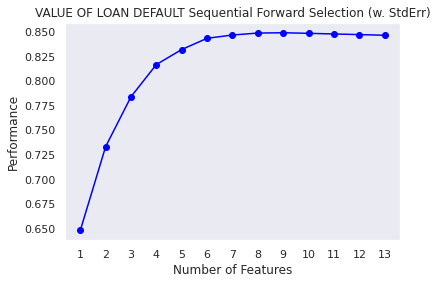

 ................... 
argmax
feature_names    (1, 2, 3, 6, 7, 8, 9, 11, 12)
avg_score                             0.848897
Name: 9, dtype: object
 ................... 
('1', '2', '3', '6', '7', '8', '9', '11', '12')
M_DEROG
M_DEBTINC
TRUNC_LOAN
TRUNC_IMP_YOJ
TRUNC_IMP_DEROG
TRUNC_IMP_DELINQ
TRUNC_IMP_CLAGE
TRUNC_IMP_CLNO
TRUNC_IMP_DEBTINC


In [106]:
"""
REGRESSION STEPWISE
"""

#V_train = W_train # Full variable list (Takes a LONG time)
V_train = W_train[ short ]
stepVarNames = list( V_train.columns.values )
maxCols = V_train.shape[1]

sfs = SFS( LinearRegression(),
           k_features=( 1, maxCols ),
           forward=True,
           floating=False,
           scoring = 'r2',
           cv=5
           )
sfs.fit(V_train.values, Z_train[ TARGET_A ].values)

theFigure = plot_sfs(sfs.get_metric_dict(), kind=None )
plt.title('VALUE OF LOAN DEFAULT Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

dfm = pd.DataFrame.from_dict( sfs.get_metric_dict()).T
dfm = dfm[ ['feature_names', 'avg_score'] ]
dfm.avg_score = dfm.avg_score.astype(float)

print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

stepVars = dfm.iloc[ maxIndex, ]
stepVars = stepVars.feature_names
print( stepVars )

finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

V_train = W_train[ finalStepVars ]
V_test = W_test[ finalStepVars ]


In [107]:
# VALUE OF LOAN DEFAULT

WHO = "REG_STEPWISE"

AMT = LinearRegression()
AMT = AMT.fit( V_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_STEP_AMT_COEF = getCoefLinear( AMT, V_train )

REG_STEP_AMT = TEST_AMT.copy()

REG_STEPWISE RMSE ACCURACY
REG_STEPWISE_Train  =  3939.7712893348926
REG_STEPWISE  =  4471.60136151949
------



VALUE OF LOAN DEFAULT
---------
Total Variables:  10
INTERCEPT  =  -13865.955879622248
M_DEROG  =  1923.7357516089062
M_DEBTINC  =  5532.991154510004
TRUNC_LOAN  =  0.800992147002944
TRUNC_IMP_YOJ  =  -91.45686330345706
TRUNC_IMP_DEROG  =  305.44463365353823
TRUNC_IMP_DELINQ  =  1074.9007570293143
TRUNC_IMP_CLAGE  =  -26.63270207009158
TRUNC_IMP_CLNO  =  263.13160954749577
TRUNC_IMP_DEBTINC  =  222.17854927110818


### Develop a linear regression model to determine the expected loss if the loan defaults. Use the variables that were selected by model.


* Calculate the RMSE for both the training data set and the test data set

In [108]:
# VALUE OF LOAN DEFAULT

WHO = "REG_SELECT"

Select_Flag_Lin = ['M_DEBTINC', 'TRUNC_LOAN', 'TRUNC_IMP_CLAGE', 'TRUNC_IMP_CLNO']

AMT = LinearRegression()
AMT = AMT.fit( W_train[Select_Flag_Lin], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[Select_Flag_Lin], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[Select_Flag_Lin], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

varNames = list( X_train.columns.values )
print(len(varNames))

REG_SEL_AMT_COEF = getCoefLinear( AMT, X_train[Select_Flag_Lin] )

REG_SEL_AMT = TEST_AMT.copy()


REG_SELECT RMSE ACCURACY
REG_SELECT_Train  =  4413.468515401338
REG_SELECT  =  4993.665109981578
------


29

VALUE OF LOAN DEFAULT
---------
Total Variables:  5
INTERCEPT  =  -5819.88869419683
M_DEBTINC  =  5183.772221998081
TRUNC_LOAN  =  0.7956983025251188
TRUNC_IMP_CLAGE  =  -27.940538443383506
TRUNC_IMP_CLNO  =  316.2804668309275


### List the RMSE for the test data set for all of the models created (tree based and regression).


In [109]:
ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT, REG_GB_AMT, REG_STEP_AMT, REG_SEL_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL VALUE OF DEFAULT MODEL ACCURACY", ALL_AMT )


ALL VALUE OF DEFAULT MODEL ACCURACY
GB_Test   =  2658.6822153725543
REG_ALL  =  4368.004791973564
REG_STEPWISE  =  4471.60136151949
REG_GB  =  4834.631645572038
RF_Test   =  4842.274906367334
REG_SELECT  =  4993.665109981578
REG_TREE  =  5173.498532555318
REG_RF  =  6024.014801820007
TREE_Test   =  6461.242833559236
------




---
**NOTES:** 

* Results with `O_` variables included:


| Model | RMSE |
| --- | --- |
| Gradient Boosting | 2553.634549128874 |
| Linear Regression (All Vars) | 3615.100638418768 |
| Linear Regression (Stepwise Vars) | 4471.60136151949 |
| Linear Regression (GB Vars) | 4834.631645572038 |
| Random Forest | 4850.713835681637 |
| Linear Regression (Bonus Bingo Vars) | 4993.665109981578 |
| Linear Regression (RF Vars) | 5173.498532555212 |
| Linear Regression (Tree Vars) | 5173.498532555317 |
| Decision Trees | 6461.242833559236 |


* Results with `O_` variables excluded: **Exactly the same results.**

---

### Discuss which one is the most accurate. Which one would you recommend using?

For predicting the ***value*** of a loan default (the classification model) the most accurate model remains the **Gradient Boosting Model.** If legal or ethical issues are not in play, then I would continue to recommend deploying the **Gradient Boosting Model** into production, because it performs the best out of all of these models. In addition the number of variables is relatively low for deploying these models so there is not much of a tradeoff associated with either speed or complexity.

There may be some legal or ethical issues associated with deploying the Gradient Boosting model in a commercial sense and then using this type of model to monitor loan holders, because it is not easy to determine exactly which variables are contributing the predictions, so these potential ethical issues may be a consideration for commercial deployment, in which case deploying the Random Forest model would be a better choice.

If legal or ethical issues arise, OR if there are concerns with the difficulty of placing a Gradient Boosting Model into production, then as a completely acceptable alternative, the accuracy and AUC values of the **Linear Regression Model (using ALL Variables)** may provide the best path forward. This alternative only leads to a slight decrease in RMSE from \$2,554 to $3,615. 

Deploying a Linear Regression model using all variables will be extremely fast and easy to deploy into production.

### For one of the Regression Models, print the coefficients. Do the variables make sense? If not, what would you recommend?

In [110]:
# VALUE OF LOAN DEFAULT

WHO = "REG_STEPWISE"

AMT = LinearRegression()
AMT = AMT.fit( V_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )
#print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

REG_STEP_AMT_COEF = getCoefLinear( AMT, V_train )

#REG_STEP_AMT = TEST_AMT.copy()


VALUE OF LOAN DEFAULT
---------
Total Variables:  10
INTERCEPT  =  -13865.955879622248
M_DEROG  =  1923.7357516089062
M_DEBTINC  =  5532.991154510004
TRUNC_LOAN  =  0.800992147002944
TRUNC_IMP_YOJ  =  -91.45686330345706
TRUNC_IMP_DEROG  =  305.44463365353823
TRUNC_IMP_DELINQ  =  1074.9007570293143
TRUNC_IMP_CLAGE  =  -26.63270207009158
TRUNC_IMP_CLNO  =  263.13160954749577
TRUNC_IMP_DEBTINC  =  222.17854927110818


The goal of the Linear Regression will be to determine the predicted value (in $) of a home loan default.

Here is a sypnopsis of these variables:

* 'INTERCEPT`: The intercept implies that all (except 2) of the variables ADD to the value of a loan default. So it makes sense that the starting point for a calculation will be less than zero.
* `M_DEROG`: If the Derogatory Marks on Credit Record is missing from the loan application, then `ADD $1,923` to expected default amount. This makes sense, as it is likely that if you have derogatory remarks, you are more risky. So if you intentionally omit this information, it is likely you are trying to hide this (and are a higher risk).
* `M_DEBTINC`: If the Debt to Income Ratio is missing from the loan application, then `ADD $5,533` to expected default amount. This makes sense, as it is likely that if you have have a high debt to income ratio, you are more risky. So if you intentionally omit this information, it is likely you are trying to hide this (and are a higher risk).
* `TRUNC_LOAN`: For every `$1` of loan value, `ADD $0.80` to the predicted value of default. This makes sense as the higher the loan, the higher a potential default amount will be.
* `TRUNC_IMP_YOJ`: This is a negative correlated variable, meaning the for each year of job history, `REDUCE $91` from the value of default. This make sense as older people with longer job history could likely to have lower rates of default.
* `TRUNC_IMP_DEROG`: Each derogatory mark on your current credit report `ADD $305` to the amount of default. This makes sense as more derogatory remarks means higher risk.
* `TRUNC_IMP_DELINQ`: Each delinquency on your current credit report `ADD $1075` to the amount of default. This makes sense as more delinquencies means higher risk.
* `TRUNC_IMP_CLAGE`: This is a negative correlated variable, meaning that for each month of credit line age, `REDUCE $27` from the value of default. This make sense as older people with longer credit history are likely to have lower rates of default.
* `TRUNC_IMP_CLNO`: Each credit line on your current credit report `ADD $263` to the amount of default. This makes sense as more lines of credit mean more debt and higher risk.
* `TRUNC_IMP_DEBTINC`: As debt to income ratio increases, there is a higher likelihood of default. This makes sense.

## **A COMBINATION OF DIFFERENT REGRESSION VARIABLES**



In the Exercise, I actually run several thousand different logistic and linear regression models based upon a short list of variables.

The number of combinations different variables grows based upon the Combinations of the number of variables present. For instance:

* One Variable has only one combination
* Two Variables (X,Y) has three different combinations: (X), (Y), and (X, Y)
* Three variables (X,Y,Z) has six different combinations: (X), (Y), (Z), (X,Y), (Y,Z), and (X,Y,Z).
* Etc.

So, if I reduce our 39 variables down to include the most prevalent Missing Flag Variables and the Continuous Variables only, then I can see how several thousand different combinations of variables influences the Accuracy and RMSE Scores. 

In [ ]:
# X_train.shape

In [ ]:
# X_train.columns

Include the most prevalent Missing Flag Variables and the Continuous Variables only

In [ ]:
# short = ['M_VALUE', 'M_DEROG', 'M_DEBTINC', 'TRUNC_LOAN', 'TRUNC_IMP_MORTDUE', 
         'TRUNC_IMP_VALUE', 'TRUNC_IMP_YOJ', 'TRUNC_IMP_DEROG', 
         'TRUNC_IMP_DELINQ', 'TRUNC_IMP_CLAGE', 'TRUNC_IMP_NINQ', 
         'TRUNC_IMP_CLNO', 'TRUNC_IMP_DEBTINC']

In [ ]:
# short

['M_VALUE',
 'M_DEROG',
 'M_DEBTINC',
 'TRUNC_LOAN',
 'TRUNC_IMP_MORTDUE',
 'TRUNC_IMP_VALUE',
 'TRUNC_IMP_YOJ',
 'TRUNC_IMP_DEROG',
 'TRUNC_IMP_DELINQ',
 'TRUNC_IMP_CLAGE',
 'TRUNC_IMP_NINQ',
 'TRUNC_IMP_CLNO',
 'TRUNC_IMP_DEBTINC']

In [ ]:
# S_train = X_train[short].copy()
# T_train = Y_train.copy()

# S_test = X_test[short].copy()
# T_test = Y_test.copy()

In [ ]:
# len(short)

13

Now create all of the Combinations of these thirteen different variables


In [ ]:
# Full_List = []
# List = list(range(0,len(short)))
# List

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
# for i in List:
#   Tuples = list(itertools.combinations(List, i+1))
#   Lists = list(map(list, Tuples))
#   #print(Lists)
#   #print(Lists[0])
#   for j in range(len(Lists)):
#     Full_List.append(Lists[j])

In [ ]:
# len(Full_List)

8191

**Now I perform 8,191 Logistic Regressions!!**

In [ ]:
# Test_Results = []

# for i in range(len(Full_List)):
#   CLM = LogisticRegression( solver='newton-cg', max_iter=1000 )
#   CLM = CLM.fit( S_train[S_train.columns[Full_List[i]]], T_train[ TARGET_F ] )

#   pred_train = CLM.predict( S_train[S_train.columns[Full_List[i]]] )
#   acc_score_train = metrics.accuracy_score(T_train[ TARGET_F ], pred_train)

#   pred_test = CLM.predict( S_test[S_train.columns[Full_List[i]]] )
#   acc_score_test = metrics.accuracy_score(T_test[ TARGET_F ], pred_test)

#   Test_Results.append([i, acc_score_test, acc_score_train])

In [ ]:
# len(Test_Results)

8191

In [ ]:
# Test_Results_df = pd.DataFrame(Test_Results, columns = ['Combination', 'Test_Accuracy', 'Train_Accuracy'])

The Test Results are provided for the specific combination of variables that occurred, sorted by highest Test Accuracy:

In [ ]:
# Test_Results_df.sort_values(by = 'Test_Accuracy', ascending=False).head(20)

,Combination,Test_Accuracy,Train_Accuracy
7219,7219,0.886745,0.883389
7885,7885,0.886745,0.883599
7297,7297,0.885906,0.884018
6059,6059,0.885906,0.884438
7844,7844,0.885906,0.877097
8115,8115,0.885067,0.884438
7914,7914,0.885067,0.884228
7223,7223,0.885067,0.878985
7889,7889,0.885067,0.878985
7864,7864,0.885067,0.884018


In [ ]:
# S_train.columns[Full_List[7219]]

Index(['M_VALUE', 'M_DEROG', 'M_DEBTINC', 'TRUNC_LOAN', 'TRUNC_IMP_DEROG',
       'TRUNC_IMP_DELINQ', 'TRUNC_IMP_CLAGE', 'TRUNC_IMP_NINQ',
       'TRUNC_IMP_DEBTINC'],
      dtype='object')

In [ ]:
# S_train.columns[Full_List[7885]]

Index(['M_VALUE', 'M_DEROG', 'M_DEBTINC', 'TRUNC_LOAN', 'TRUNC_IMP_VALUE',
       'TRUNC_IMP_DEROG', 'TRUNC_IMP_DELINQ', 'TRUNC_IMP_CLAGE',
       'TRUNC_IMP_NINQ', 'TRUNC_IMP_DEBTINC'],
      dtype='object')

In [ ]:
# S_train.columns[Full_List[5933]]

Index(['M_VALUE', 'M_DEROG', 'M_DEBTINC', 'TRUNC_LOAN', 'TRUNC_IMP_DELINQ',
       'TRUNC_IMP_CLAGE', 'TRUNC_IMP_NINQ', 'TRUNC_IMP_DEBTINC'],
      dtype='object')

Here is a Histogram of all Test Accuracies:

(array([ 484.,  642., 1331.,  898.,  688.,   76.,  949., 1418., 1332.,
         373.]),
 array([0.78439597, 0.79463087, 0.80486577, 0.81510067, 0.82533557,
        0.83557047, 0.84580537, 0.85604027, 0.86627517, 0.87651007,
        0.88674497]),
 <a list of 10 Patch objects>)

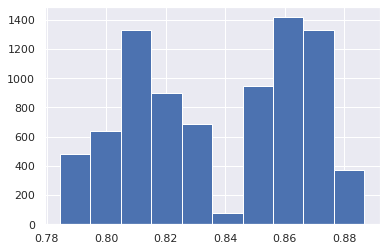

In [ ]:
# plt.hist(Test_Results_df['Test_Accuracy'])

Here is a linear plot of the Test Accuracy with the x-axis being the combination number. The lower combinations are ones with lower total numbers of variables

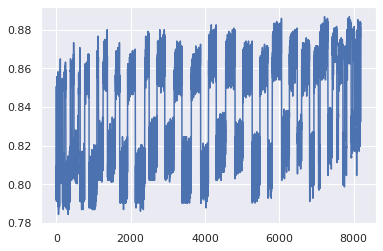

In [ ]:
# plt.plot(Test_Results_df['Combination'],Test_Results_df['Test_Accuracy'])

I visually see that for the lower combinations of variables (i.e. Combination Number < 2000) there is a spike in Test Accuracy that exceeds 88%. So, to dramatically simplify the model (i.e. use many less variables), I look at the best Accuracy amongst the Lowest Combination Numbers

In [ ]:
# Test_Results_df[0:2000].sort_values(by = 'Test_Accuracy', ascending=False).head(20)

,Combination,Test_Accuracy,Train_Accuracy
1369,1369,0.880034,0.873322
1127,1127,0.876678,0.876678
1311,1311,0.875000,0.870805
1363,1363,0.875000,0.873742
1283,1283,0.874161,0.870386
1332,1332,0.874161,0.870386
467,467,0.873322,0.870805
1357,1357,0.873322,0.876049
1699,1699,0.873322,0.874161
1368,1368,0.873322,0.870386


In [ ]:
# S_train.columns[Full_List[1369]]

Index(['M_VALUE', 'M_DEBTINC', 'TRUNC_IMP_DELINQ', 'TRUNC_IMP_CLAGE',
       'TRUNC_IMP_DEBTINC'],
      dtype='object')

So in Conclusion: This particular combination of variables will result in a Test Accuracy of 88%. Pretty good considering there are only five (5) variables needed!! Variables:  `'M_VALUE', 'M_DEBTINC', 'TRUNC_IMP_DELINQ', 'TRUNC_IMP_CLAGE',
       'TRUNC_IMP_DEBTINC'`

**Now I perform 8,191 Linear Regressions to predict the Loan Default Amount**

In [ ]:
# F = ~ T_train[ TARGET_A ].isna()
# Q_train = S_train[F].copy()
# R_train = T_train[F].copy()

# F = ~ T_test[ TARGET_A ].isna()
# Q_test = S_test[F].copy()
# R_test = T_test[F].copy()

In [ ]:
# Test_Results_Lin = []

# for i in range(len(Full_List)):
#   AMT = LinearRegression()
#   AMT = AMT.fit( Q_train[Q_train.columns[Full_List[i]]], R_train[ TARGET_A ] )

#   amt_pred_train = AMT.predict( Q_train[Q_train.columns[Full_List[i]]] )
#   amt_RMSE_train = math.sqrt( metrics.mean_squared_error(R_train[ TARGET_A ], amt_pred_train))

#   amt_pred_test = AMT.predict( Q_test[Q_test.columns[Full_List[i]]] )
#   amt_RMSE_test = math.sqrt( metrics.mean_squared_error(R_test[ TARGET_A ], amt_pred_test))

#   Test_Results_Lin.append([i, amt_RMSE_test, amt_RMSE_train])

In [ ]:
# Test_Results_Lin_df = pd.DataFrame(Test_Results_Lin, columns = ['Combination', 'Test_RMSE', 'Train_RMSE'])

In [ ]:
# Test_Results_Lin_df.sort_values(by = 'Test_RMSE', ascending=True).head(20)

,Combination,Test_RMSE,Train_RMSE
8063,8063,4466.194671,3939.663435
8167,8167,4466.639357,3939.630623
8173,8173,4467.152591,3939.647297
8056,8056,4467.391284,3939.634413
8189,8189,4467.573862,3939.615234
8059,8059,4468.055880,3949.568718
8172,8172,4468.357331,3939.619508
8066,8066,4469.144843,3949.768856
7640,7640,4469.999695,3949.640803
8129,8129,4470.308443,3939.021162


Here is a Histogram of all RMSE:

(array([ 987., 1990., 1119.,    0.,    0.,    0.,    5., 1454., 2097.,
         539.]),
 array([ 4466.19467144,  5177.21294199,  5888.23121254,  6599.24948309,
         7310.26775364,  8021.28602419,  8732.30429475,  9443.3225653 ,
        10154.34083585, 10865.3591064 , 11576.37737695]),
 <a list of 10 Patch objects>)

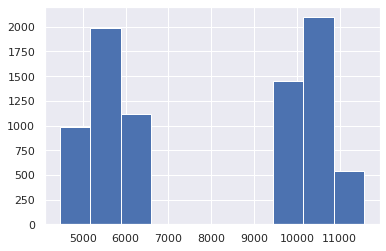

In [ ]:
# plt.hist(Test_Results_Lin_df['Test_RMSE'])

Here is a linear plot of the RMSE with the x-axis being the combination number. The lower combinations are ones with lower total numbers of variables

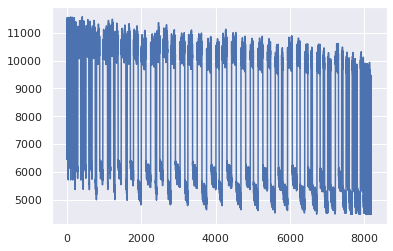

In [ ]:
# plt.plot(Test_Results_Lin_df['Combination'],Test_Results_Lin_df['Test_RMSE'])

I visually see that for the lower combinations of variables (i.e. Combination Number < 1000) there is a spike in RMSE where it dips below 5000. So, to dramatically simplify the model (i.e. use many less variables), I look at the lowest RMSE amongst the Lowest Combination Numbers

In [ ]:
# Test_Results_Lin_df[0:1000].sort_values(by = 'Test_RMSE', ascending=True).head(20)

,Combination,Test_RMSE,Train_RMSE
793,793,4993.665110,4413.468515
797,797,5173.498533,4579.240752
781,781,5237.079853,4764.781448
790,790,5282.145991,4696.912449
788,788,5298.321899,5181.416500
795,795,5325.265515,4803.008441
786,786,5333.238625,4775.363204
604,604,5356.048331,4805.420687
219,219,5362.236711,4807.523610
775,775,5365.958800,4807.487137


In [ ]:
# Q_train.columns[Full_List[793]]

Index(['M_DEBTINC', 'TRUNC_LOAN', 'TRUNC_IMP_CLAGE', 'TRUNC_IMP_CLNO'], dtype='object')

So in Conclusion: This particular combination of variables will result in a RMSE of 4994. Pretty good considering there are only four (4) variables needed!! Variables:  `'M_DEBTINC', 'TRUNC_LOAN', 'TRUNC_IMP_CLAGE', 'TRUNC_IMP_CLNO'`

## Pre-Process the Data Set:


### See Assignment 01 above
Steps 1 through 7 address the data preparation that must occur immediately prior to creating the training and test data sets, summarized below:

* Step 1: Download the HMEQ Data set
* Step 2: Read the data into Python
* Step 3: Explore both the input and target variables using statistical techniques
* Step 4: Explore both the input and target variables using graphs and other visualization.
* Step 5: Look for relationships between the input variables and the targets.
* Step 6: Fix (impute) all missing data.
* Step 7: Convert all categorical variables into numeric variables (One Hot Encoding)


## Create a Training and Test Data Set

* See Assignment 02 above, which addresses Creating a Training and Test Data Set 
* It is best practice to scale the data, in this case using `MinMaxScaler()`


In [111]:
# Transform the data

theScaler = MinMaxScaler()
theScaler.fit( X_train )

U_train = theScaler.transform( X_train ) # Generates a numpy array
U_test = theScaler.transform( X_test ) # Generates a numpy array

U_train = pd.DataFrame( U_train )
U_test = pd.DataFrame( U_test )

U_train.columns = list( X_train.columns.values )
U_test.columns = list( X_train.columns.values )

U_train.shape

(4768, 29)

In [112]:
# Transform the data for the Crash Value

V_train = theScaler.transform( W_train )
V_test = theScaler.transform( W_test )

V_train = pd.DataFrame( V_train )
V_test = pd.DataFrame( V_test )

V_train.columns = list( W_train.columns.values )
V_test.columns = list( W_train.columns.values )

V_train.shape

(941, 29)

## ***Tensor Flow Model To Predict Loan Defaults:***

 * Develop a model using Tensor Flow that will predict Loan Default.

In [113]:
WHO = "TF_Relu"

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.relu
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 200

F_theUnits = int( 2.5 * F_theShapeSize ) # Starting point 2.0 as "rule of thumb"

F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )

CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

TF_RELU_CLM = TEST_CLM.copy()

#### Calculate the accuracy of the model on both the training and test data set

In [114]:
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

TF_Relu CLASSIFICATION ACCURACY
TF_Relu_Train  =  0.9632969798657718
TF_Relu  =  0.9211409395973155
------




#### Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.


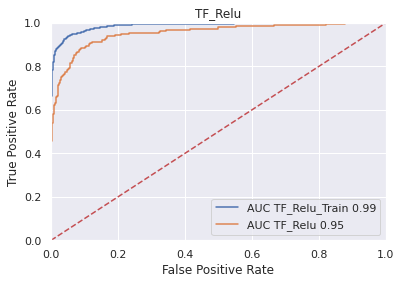

In [115]:
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 

### Explore the **SoftPlus** Activation Function

In [116]:
WHO = "TF_SoftPlus"

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.softplus
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 200

F_theUnits = int( 2.5 * F_theShapeSize ) # Starting point 2.0 as "rule of thumb"

F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )

CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

TF_SOFTPLUS_CLM = TEST_CLM.copy()

#### Calculate the accuracy of the model on both the training and test data set

In [117]:
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

TF_SoftPlus CLASSIFICATION ACCURACY
TF_SoftPlus_Train  =  0.9110738255033557
TF_SoftPlus  =  0.9035234899328859
------




#### Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.


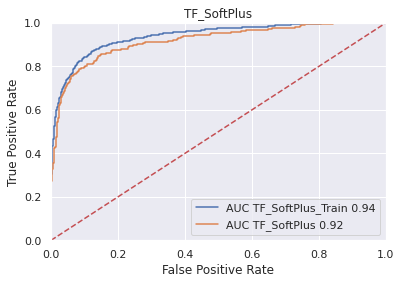

In [118]:
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 

### Explore the **TanH** Activation Function

In [119]:
WHO = "TF_TanH"

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.tanh
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 200

F_theUnits = int( 2.5 * F_theShapeSize ) # Starting point 2.0 as "rule of thumb"

F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )

CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

TF_TANH_CLM = TEST_CLM.copy()

#### Calculate the accuracy of the model on both the training and test data set

In [120]:
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

TF_TanH CLASSIFICATION ACCURACY
TF_TanH_Train  =  0.9278523489932886
TF_TanH  =  0.9119127516778524
------




#### Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.


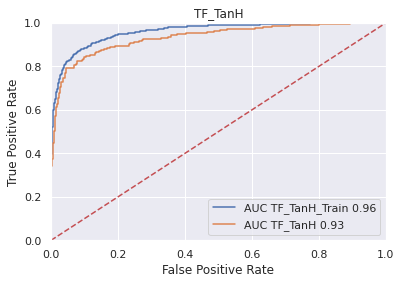

In [121]:
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 

### Explore the **Sigmoid** Activation Function

In [122]:
WHO = "TF_Sigmoid"

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.sigmoid
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 200

F_theUnits = int( 2.5 * F_theShapeSize ) # Starting point 2.0 as "rule of thumb"

F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )

CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

TF_SIGMOID_CLM = TEST_CLM.copy()

#### Calculate the accuracy of the model on both the training and test data set

In [123]:
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

TF_Sigmoid CLASSIFICATION ACCURACY
TF_Sigmoid_Train  =  0.895763422818792
TF_Sigmoid  =  0.8884228187919463
------




#### Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.


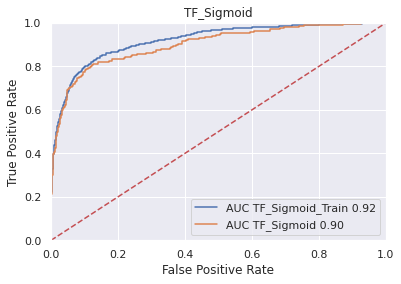

In [124]:
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 

### Explore one hidden layer

In [125]:
WHO = "TF_1Hidden"

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.relu
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 200

F_theUnits = int( 2.5 * F_theShapeSize ) # Starting point 2.0 as "rule of thumb"

F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_02 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )

CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_02 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

TF_1HIDDEN_CLM = TEST_CLM.copy()

#### Calculate the accuracy of the model on both the training and test data set

In [126]:
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

TF_1Hidden CLASSIFICATION ACCURACY
TF_1Hidden_Train  =  0.9920302013422819
TF_1Hidden  =  0.9194630872483222
------




#### Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.


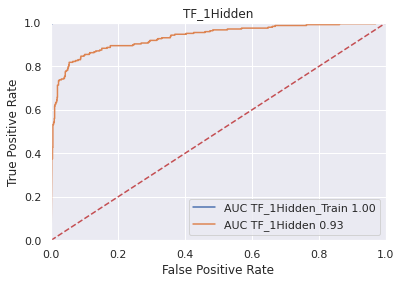

In [127]:
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 

### Explore two hidden layers

In [128]:
WHO = "TF_2Hidden"

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.relu
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 200

F_theUnits = int( 2.5 * F_theShapeSize ) # Starting point 2.0 as "rule of thumb"

F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_02 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation )
F_LAYER_03 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )

CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_02 )
CLM.add( F_LAYER_03 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

TF_2HIDDEN_CLM = TEST_CLM.copy()

#### Calculate the accuracy of the model on both the training and test data set

In [129]:
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

TF_2Hidden CLASSIFICATION ACCURACY
TF_2Hidden_Train  =  0.9991610738255033
TF_2Hidden  =  0.9345637583892618
------




#### Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.


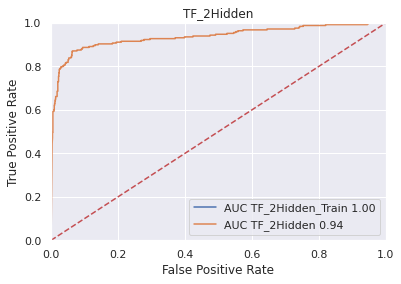

In [130]:
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 

### Explore a Dropout Layer

In [131]:
WHO = "TF_1Hid1Drop"

F_theShapeSize = U_train.shape[1]
F_theActivation = tf.keras.activations.relu
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 200

F_theUnits = int( 2.5 * F_theShapeSize ) # Starting point 2.0 as "rule of thumb"

F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
F_LAYER_02 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )

CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_DROP )
CLM.add( F_LAYER_02 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, U_train, Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, U_test, Y_test[ TARGET_F ] )

TF_1HID1DROP_CLM = TEST_CLM.copy()

#### Calculate the accuracy of the model on both the training and test data set

In [132]:
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

TF_1Hid1Drop CLASSIFICATION ACCURACY
TF_1Hid1Drop_Train  =  0.9838506711409396
TF_1Hid1Drop  =  0.9345637583892618
------




#### Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.


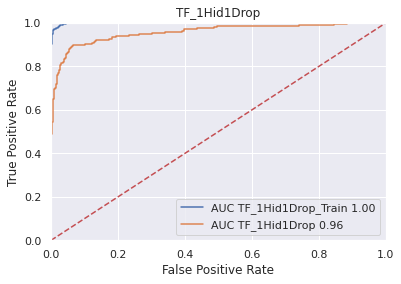

In [133]:
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 

### Explore using a variable selection technique

In [134]:
# Select variables based upon Gradient Boosting
GB_flag = []
for i in vars_GB_flag :
    #print(i)
    theVar = i[0]
    GB_flag.append( theVar )

G_train = U_train[ GB_flag ]
G_test = U_test[ GB_flag ]

In [135]:
WHO = "TF_Relu_GBVar"

F_theShapeSize = G_train.shape[1]
F_theActivation = tf.keras.activations.relu
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
F_theEpochs = 200

F_theUnits = int( 2.1 * F_theShapeSize ) # Starting point 2.0 as "rule of thumb"

F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )

CLM = tf.keras.Sequential()
CLM.add( F_LAYER_01 )
CLM.add( F_LAYER_OUTPUT )
CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
CLM.fit( G_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

TRAIN_CLM = get_TF_ProbAccuracyScores( WHO + "_Train", CLM, G_train, Y_train[ TARGET_F ] )
TEST_CLM = get_TF_ProbAccuracyScores( WHO, CLM, G_test, Y_test[ TARGET_F ] )

TF_RELU_GBVAR_CLM = TEST_CLM.copy()

#### Calculate the accuracy of the model on both the training and test data set

In [136]:
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [ TRAIN_CLM, TEST_CLM ] )

TF_Relu_GBVar CLASSIFICATION ACCURACY
TF_Relu_GBVar_Train  =  0.8890520134228188
TF_Relu_GBVar  =  0.8875838926174496
------




#### Create a graph that shows the ROC curves for both the training and test data set. Clearly label each curve and display the Area Under the ROC curve.


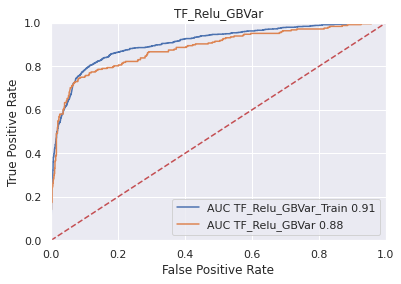

In [137]:
print_ROC_Curve( WHO, [ TRAIN_CLM, TEST_CLM ] ) 

### Display a ROC curve for the test data with all your models on the same graph (All Neural Network). 


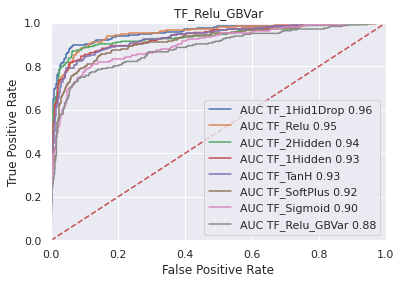

ALL CLASSIFICATION ACCURACY
TF_1Hid1Drop  =  0.9345637583892618
TF_2Hidden  =  0.9345637583892618
TF_Relu  =  0.9211409395973155
TF_1Hidden  =  0.9194630872483222
TF_TanH  =  0.9119127516778524
TF_SoftPlus  =  0.9035234899328859
TF_Sigmoid  =  0.8884228187919463
TF_Relu_GBVar  =  0.8875838926174496
------




In [138]:
ALL_CLM = [ TF_RELU_CLM, TF_SOFTPLUS_CLM, TF_TANH_CLM, TF_SIGMOID_CLM, 
           TF_1HIDDEN_CLM, TF_2HIDDEN_CLM, TF_1HID1DROP_CLM, TF_RELU_GBVAR_CLM ]

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( WHO, ALL_CLM ) 

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )

### Display a ROC curve for the test data with all your models on the same graph (All Models, with Simple NN Model (Relu)). 


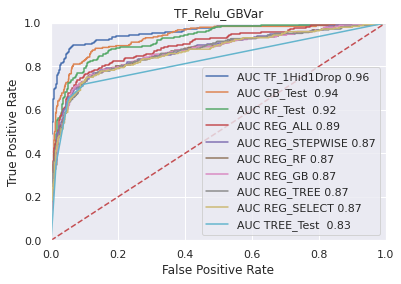

ALL CLASSIFICATION ACCURACY
TF_1Hid1Drop  =  0.9345637583892618
GB_Test   =  0.9068791946308725
REG_ALL  =  0.8884228187919463
REG_STEPWISE  =  0.886744966442953
TREE_Test   =  0.8859060402684564
RF_Test   =  0.8808724832214765
REG_GB  =  0.8800335570469798
REG_SELECT  =  0.8800335570469798
REG_RF  =  0.8783557046979866
REG_TREE  =  0.87751677852349
------




In [141]:
ALL_CLM = [ TREE_CLM, RF_CLM, GB_CLM, REG_ALL_CLM, REG_TREE_CLM, REG_RF_CLM, 
           REG_GB_CLM, REG_STEP_CLM, REG_SEL_CLM, TF_1HID1DROP_CLM]

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[4], reverse=True )
print_ROC_Curve( WHO, ALL_CLM ) 

ALL_CLM = sorted( ALL_CLM, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_CLM )



In [138]:
finalStepVars

['M_VALUE',
 'M_DEROG',
 'M_DEBTINC',
 'TRUNC_LOAN',
 'TRUNC_IMP_VALUE',
 'TRUNC_IMP_DEROG',
 'TRUNC_IMP_DELINQ',
 'TRUNC_IMP_CLAGE',
 'TRUNC_IMP_NINQ',
 'TRUNC_IMP_DEBTINC']

### Discuss which one is the most accurate. Which one would you recommend using?

For predicting the ***probability*** of a loan default (the classification model) the most accurate model is now the  **Deep Neural Network, with 1 Hidden Layer and 1 Dropout Layer, using Relu**. Here are the specifications for the model implemented:

* Type of Neural Network: Sequential
* Number of Inputs (Variables): 29
* Activation: Relu
* Loss Metric: Sparse Categorical Cross Entropy
* Optimizer: Adam
* Epochs: 200
* Input Layers: 1 Dense
* Nodes in 1st Layer: 72
* 20% Dropout Layer
* Hidden Layer: 1 Dense
* Nodes in 1 Hidden Layer: 72
* Output Layer: Softmax, two outputs


I would recommend deploying this neural network model. It calculates relatively quickly, and provides a better prediction rate at 93.5% Accuracy over the next best model which is at 90.7% accurate.

There may be some legal or ethical issues associated with deploying the Neural Network model in a commercial sense and then using this type of model to "reject" loan applicants, because it is not easy to determine exactly which variables are contributing the predictions.

If legal or ethical issues arise, OR if there are concerns with the difficulty of placing a Neural Network Model into production, then as a completely acceptable alternative, the accuracy and AUC values of the **Logistic Regression Model (using Stepwise-determined Variables)** may provide the best path forward. This model acheives 88.7% Accuracy (only a 5% decrease over NN) only using ten (10) variables.

Variables which were selected for the Logistic Regression Model:

|Variable|
|---|
| `M_VALUE` |
|`M_DEROG`|
|`M_DEBTINC`|
|`TRUNC_LOAN`|
|`TRUNC_IMP_VALUE`|
|`TRUNC_IMP_DEROG`|
|`TRUNC_IMP_DELINQ`|
|`TRUNC_IMP_CLAGE`|
|`TRUNC_IMP_NINQ`|
|`TRUNC_IMP_DEBTINC`|

## ***Tensor Flow Model to Predict Loss Given Default:***

 * Develop a model using Tensor Flow that will predict Loan Default.


In [144]:
WHO = "TF_Relu"

A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.relu
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 1000

A_theUnits = int( 2.8 * A_theShapeSize  ) # Starting point 2.0 as "rule of thumb"

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )

TF_RELU_AMT = TEST_AMT.copy()

### Calculate the RMSE for both the training data set and the test data set

In [145]:
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_Relu RMSE ACCURACY
TF_Relu_Train  =  5694.268175507965
TF_Relu  =  6833.284480552232
------




### Explore the **SoftPlus** Activation Function

In [146]:
WHO = "TF_SoftPlus"

A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.softplus
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 1000

A_theUnits = int( 2.8 * A_theShapeSize  ) # Starting point 2.0 as "rule of thumb"

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )

TF_SOFTPLUS_AMT = TEST_AMT.copy()

### Calculate the RMSE for both the training data set and the test data set

In [147]:
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_SoftPlus RMSE ACCURACY
TF_SoftPlus_Train  =  5263.497692412647
TF_SoftPlus  =  6333.871235113374
------




### Explore the **TanH** Activation Function

In [148]:
WHO = "TF_TanH"

A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.tanh
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 1000

A_theUnits = int( 2.8 * A_theShapeSize  ) # Starting point 2.0 as "rule of thumb"

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )

TF_TANH_AMT = TEST_AMT.copy()

### Calculate the RMSE for both the training data set and the test data set

In [149]:
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_TanH RMSE ACCURACY
TF_TanH_Train  =  15298.912512088784
TF_TanH  =  15863.689225672397
------




### Explore the **Sigmoid** Activation Function

In [150]:
WHO = "TF_Sigmoid"

A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.sigmoid
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 1000

A_theUnits = int( 2.8 * A_theShapeSize  ) # Starting point 2.0 as "rule of thumb"

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )

TF_SIGMOID_AMT = TEST_AMT.copy()

### Calculate the RMSE for both the training data set and the test data set

In [151]:
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_Sigmoid RMSE ACCURACY
TF_Sigmoid_Train  =  15306.016536681387
TF_Sigmoid  =  15870.702205187594
------




### Explore one hidden layer

In [152]:
WHO = "TF_1Hidden"

A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.softplus
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 1000

A_theUnits = int( 2.8 * A_theShapeSize  ) # Starting point 2.0 as "rule of thumb"

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )

TF_1HIDDEN_AMT = TEST_AMT.copy()

### Calculate the RMSE for both the training data set and the test data set

In [153]:
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_1Hidden RMSE ACCURACY
TF_1Hidden_Train  =  1404.9312465136388
TF_1Hidden  =  2171.695245142202
------




### Explore two hidden layers

In [154]:
WHO = "TF_2Hidden"

A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.softplus
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 1000

A_theUnits = int( 2.8 * A_theShapeSize  ) # Starting point 2.0 as "rule of thumb"

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_03 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_03 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )

TF_2HIDDEN_AMT = TEST_AMT.copy()

### Calculate the RMSE for both the training data set and the test data set

In [155]:
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_2Hidden RMSE ACCURACY
TF_2Hidden_Train  =  1055.1158228499455
TF_2Hidden  =  1866.126268557183
------




### Explore a Dropout Layer

In [156]:
WHO = "TF_1Hid1Drop"

A_theShapeSize = V_train.shape[1]
A_theActivation = tf.keras.activations.softplus
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 1000

A_theUnits = int( 2.8 * A_theShapeSize  ) # Starting point 2.0 as "rule of thumb"

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_DROP )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, V_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, V_test, Z_test[TARGET_A] )

TF_1HID1DROP_AMT = TEST_AMT.copy()

### Calculate the RMSE for both the training data set and the test data set

In [157]:
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_1Hid1Drop RMSE ACCURACY
TF_1Hid1Drop_Train  =  3018.0249828621286
TF_1Hid1Drop  =  3385.0478303961677
------




### Explore using a variable selection technique

In [158]:
# Select variables based upon Gradient Boosting

GB_amt = []
for i in vars_GB_amt :
    print(i)
    theVar = i[0]
    GB_amt.append( theVar )

H_train = V_train[ GB_amt ]
H_test = V_test[ GB_amt ]

('TRUNC_LOAN', 100)
('TRUNC_IMP_CLNO', 14)
('TRUNC_IMP_DEBTINC', 6)
('M_DEBTINC', 5)
('TRUNC_IMP_CLAGE', 4)


In [159]:
WHO = "TF_SoftPlus_GBAmt"

A_theShapeSize = H_train.shape[1]
A_theActivation = tf.keras.activations.softplus
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 1000

A_theUnits = int( 2.8 * A_theShapeSize  ) # Starting point 2.0 as "rule of thumb"

A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit( H_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, H_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, H_test, Z_test[TARGET_A] )

TF_SOFTPLUS_GB_AMT = TEST_AMT.copy()

### Calculate the RMSE for both the training data set and the test data set

In [160]:
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_SoftPlus_GBAmt RMSE ACCURACY
TF_SoftPlus_GBAmt_Train  =  8687.811030725303
TF_SoftPlus_GBAmt  =  9562.782175052069
------




### List the RMSE for the test data set for all of the models created (All Neural Network).

In [161]:
ALL_AMT = [ TF_RELU_AMT, TF_SOFTPLUS_AMT, TF_TANH_AMT, TF_SIGMOID_AMT,
           TF_1HIDDEN_AMT, TF_2HIDDEN_AMT, TF_1HID1DROP_AMT, TF_SOFTPLUS_GB_AMT]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL DAMAGE MODEL ACCURACY", ALL_AMT )

ALL DAMAGE MODEL ACCURACY
TF_2Hidden  =  1866.126268557183
TF_1Hidden  =  2171.695245142202
TF_1Hid1Drop  =  3385.0478303961677
TF_SoftPlus  =  6333.871235113374
TF_Relu  =  6833.284480552232
TF_SoftPlus_GBAmt  =  9562.782175052069
TF_TanH  =  15863.689225672397
TF_Sigmoid  =  15870.702205187594
------




### List the RMSE for the test data set for all of the models created (All Models, with Deep NN Model (Softplus)).

In [162]:
ALL_AMT = [ TF_2HIDDEN_AMT, TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT,
           REG_RF_AMT, REG_GB_AMT, REG_STEP_AMT, REG_SEL_AMT]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL DAMAGE MODEL ACCURACY", ALL_AMT )

ALL DAMAGE MODEL ACCURACY
TF_2Hidden  =  1836.6912927613284
GB_Test   =  2658.6822153725543
REG_ALL  =  4368.004791973564
REG_STEPWISE  =  4471.60136151949
REG_GB  =  4834.631645572038
RF_Test   =  4842.274906367334
REG_SELECT  =  4993.665109981578
REG_TREE  =  5173.498532555318
REG_RF  =  6024.014801820007
TREE_Test   =  6461.242833559236
------




### Discuss which one is the most accurate. Which one would you recommend using?

For predicting the ***value*** of a loan default (the continuous variable model) the most accurate model is now the  **Deep Neural Network with 2 Hidden Layers, using Softplus**. Here are the specifications for the model implemented:

* Type of Neural Network: Sequential
* Number of Inputs (Variables): 29
* Activation: Softplus
* Loss Metric: Mean Squared Error
* Optimizer: Adam
* Epochs: 1000
* Input Layers: 1 Dense
* Nodes in 1st Layer: 81
* Hidden Layers: 2 Dense
* Nodes in 2 Hidden Layers: 81
* Output Layer: Linear, one output

If legal or ethical issues are not in play, then I would continue to recommend deploying the **Deep Neural Network** into production, because it performs the best out of all of these models. In addition the number of variables is relatively low for deploying these models so there is not much of a tradeoff associated with either speed or complexity.

If legal or ethical issues arise, OR if there are concerns with the difficulty of placing a Neural Network Model into production, then as a completely acceptable alternative, the accuracy and AUC values of the **Linear Regression Model (using Stepwise-determined Variables)** may provide the best path forward. This alternative only leads to a slight decrease in RMSE from \$1,837 to $4,472. 

Deploying a Linear Regression model using 10 variables will be extremely fast and easy to deploy into production.

Variables which were selected for the Logistic Regression Model:

|Variable|
|---|
| `M_VALUE` |
|`M_DEROG`|
|`M_DEBTINC`|
|`TRUNC_LOAN`|
|`TRUNC_IMP_VALUE`|
|`TRUNC_IMP_DEROG`|
|`TRUNC_IMP_DELINQ`|
|`TRUNC_IMP_CLAGE`|
|`TRUNC_IMP_NINQ`|
|`TRUNC_IMP_DEBTINC`|

# **TEST NUMBER OF NODES IN LINEAR NN**

In [160]:
test = np.array(range(1,31,1))
test_range = test/10
test_range

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])

In [161]:
test_results_clm = []

for i in test_range:

  F_theShapeSize = U_train.shape[1]
  F_theActivation = tf.keras.activations.relu
  F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
  F_theOptimizer = tf.keras.optimizers.Adam()
  F_theEpochs = 200

  F_theUnits = int( i * F_theShapeSize )

  F_LAYER_01 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize )
  F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )

  CLM = tf.keras.Sequential()
  CLM.add( F_LAYER_01 )
  CLM.add( F_LAYER_OUTPUT )
  CLM.compile( loss=F_theLossMetric, optimizer=F_theOptimizer)
  CLM.fit( U_train, Y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

  probs_train = CLM.predict_proba( U_train )
  pred_list_train = []
  for p in probs_train :
    pred_list_train.append( np.argmax( p ) )
  pred_train = np.array( pred_list_train )
  acc_score_train = metrics.accuracy_score(Y_train[ TARGET_F ], pred_train)

  probs_test = CLM.predict_proba( U_test )
  pred_list_test = []
  for p in probs_test :
    pred_list_test.append( np.argmax( p ) )
  pred_test = np.array( pred_list_test )
  acc_score_test = metrics.accuracy_score(Y_test[ TARGET_F ], pred_test)

  test_results_clm.append([i, acc_score_train, acc_score_test])
  print(test_results_clm[int(i*10)-1])

[0.1, 0.8909395973154363, 0.8859060402684564]
[0.2, 0.90876677852349, 0.9018456375838926]
[0.3, 0.9138003355704698, 0.8993288590604027]
[0.4, 0.9182046979865772, 0.9001677852348994]
[0.5, 0.9200922818791947, 0.9093959731543624]
[0.6, 0.9282718120805369, 0.9060402684563759]
[0.7, 0.924496644295302, 0.9077181208053692]
[0.8, 0.9291107382550335, 0.9001677852348994]
[0.9, 0.9337248322147651, 0.910234899328859]
[1.0, 0.9337248322147651, 0.9135906040268457]
[1.1, 0.9427432885906041, 0.9135906040268457]
[1.2, 0.9412751677852349, 0.915268456375839]
[1.3, 0.9444211409395973, 0.9219798657718121]
[1.4, 0.9471476510067114, 0.9219798657718121]
[1.5, 0.9484060402684564, 0.9211409395973155]
[1.6, 0.9523909395973155, 0.9253355704697986]
[1.7, 0.9402265100671141, 0.915268456375839]
[1.8, 0.9563758389261745, 0.9194630872483222]
[1.9, 0.946518456375839, 0.9203020134228188]
[2.0, 0.9521812080536913, 0.924496644295302]
[2.1, 0.9567953020134228, 0.9261744966442953]
[2.2, 0.958263422818792, 0.918624161073825

**Based on these results, a factor of 2.5 provides best results**

# **TEST NUMBER OF NODES IN LINEAR NN**



In [158]:
test = np.array(range(1,31,1))
test_range = test/10
test_range

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])

In [159]:
test_results_amt =[]

for i in test_range:
  
  A_theShapeSize = V_train.shape[1]
  A_theActivation = tf.keras.activations.relu
  A_theLossMetric = tf.keras.losses.MeanSquaredError()
  A_theOptimizer = tf.keras.optimizers.Adam()
  A_theEpochs = 1000

  A_theUnits = int( i*A_theShapeSize  )

  A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
  #A_LAYER_DROP = tf.keras.layers.Dropout( 0.2 )
  #A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
  A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )
  
  AMT = tf.keras.Sequential()
  AMT.add( A_LAYER_01 )
  #AMT.add( A_LAYER_DROP )
  #AMT.add( A_LAYER_02 )
  AMT.add( A_LAYER_OUTPUT )
  AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer )
  AMT.fit( V_train, Z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

  RMSE = math.sqrt( metrics.mean_squared_error( Z_test[TARGET_A], AMT.predict( V_test )))

  test_results_amt.append([i, RMSE])
  print(test_results_amt[int(i*10)-1])  

[0.1, 10488.622999879943]
[0.2, 10154.573579665412]
[0.3, 9795.505361101985]
[0.4, 9677.112969054615]
[0.5, 9244.133892345653]
[0.6, 9331.46285558128]
[0.7, 8819.260466868547]
[0.8, 8797.653161448494]
[0.9, 8518.904588978476]
[1.0, 8818.814309865718]
[1.1, 8641.478480103053]
[1.2, 8712.585424849327]
[1.3, 8214.639510392039]
[1.4, 8244.369319120548]
[1.5, 8336.737702878116]
[1.6, 7555.445101628355]
[1.7, 7932.552103084742]
[1.8, 7602.806089075143]
[1.9, 7365.244727255847]
[2.0, 7483.50878678856]
[2.1, 7496.998634662242]
[2.2, 7042.638324183079]
[2.3, 7620.8527409553]
[2.4, 7185.919474668838]
[2.5, 7142.692095557999]
[2.6, 6946.54487578427]
[2.7, 6898.543024697972]
[2.8, 6792.345502025029]
[2.9, 7180.58923241354]
[3.0, 6824.500259217248]


**Based on these results, a factor of 2.8 provides best results**